In [199]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [200]:
# Helper (support)
from support import input_helper

In [201]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 9)

In [4]:
# Directory with datasets:
ROOT_DIR = "RawData"

# Define path to save figures:
path_img = (
    r'C:\Users\souvi\Documents\These\90_Presentations & Writting\50_Papers\2020_Spring_MEFA of the Arch Glass Ind\IMG'
)

In [5]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale=1)

In [6]:
pd.set_option('precision', 2)

# Upload Datasets

In [7]:
# Belgian dataset:
BE_data = input_helper.get_data('BE_RawData_VPython.xlsx', directory=ROOT_DIR)

# French dataset:
FR_data = input_helper.get_data('FR_RawData_VPython.xlsx', directory=ROOT_DIR)

# European dataset:
EU_data = input_helper.get_data('EU_RawData_VPython.xlsx', directory=ROOT_DIR)

In [8]:
# Sheets contained by datasets:
print("BE_data, sheet names = \n {}\n".format(BE_data.sheet_names))
print("FR_data, sheet names = \n {}\n".format(FR_data.sheet_names))
print("EU_data, sheet names = \n {}\n".format(EU_data.sheet_names))

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS', 'Population']

FR_data, sheet names = 
 ['References', 'prod', 'import', 'export', 'Population', 'MatEnergy_WindowGlass', 'MatEnergy_PlateGlass', 'RawMat_Intensity', 'Energy_Intensity', 'emissions']

EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs']



# Flat Glass Production in Europe

## Creating a Dataframe for Flat Glass Flows

In [9]:
# Create dataframe for flat glass production:
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [10]:
# Add import and export flows:
EU_Imp = EU_data.parse('import').set_index(['Nbr of countries', 'year'])
EU_Exp = EU_data.parse('export').set_index(['Nbr of countries', 'year'])

In [11]:
# Create a single dataframe for flat glass flows in Europe:
EU = pd.concat([EU_Prod['flat glass, kt'],
                EU_Imp['flat glass, kt'],
                EU_Exp['flat glass, kt']],
               axis=1, keys=[('Production [kt]'),
                             ('Import [kt]'),
                             ('Export [kt]')],
               names=['Flow']).stack(dropna=False)

EU = EU.unstack()

In [12]:
# Overview of the EU dataframe:
EU

Flow                   Production [kt]  Import [kt]  Export [kt]
Nbr of countries year                                           
6                1945              NaN          NaN          NaN
                 1946              NaN          NaN          NaN
                 1947              NaN          NaN          NaN
                 1948              NaN          NaN          NaN
                 1949              NaN          NaN          NaN
...                                ...          ...          ...
28               2015           9641.0      1079.10      1187.54
                 2016           9835.0      1255.01      1192.21
                 2017          10665.0      1534.99      1158.69
                 2018          10643.0      1673.63      1178.92
                 2019          10840.0          NaN          NaN

[77 rows x 3 columns]

## Flat Glass Production

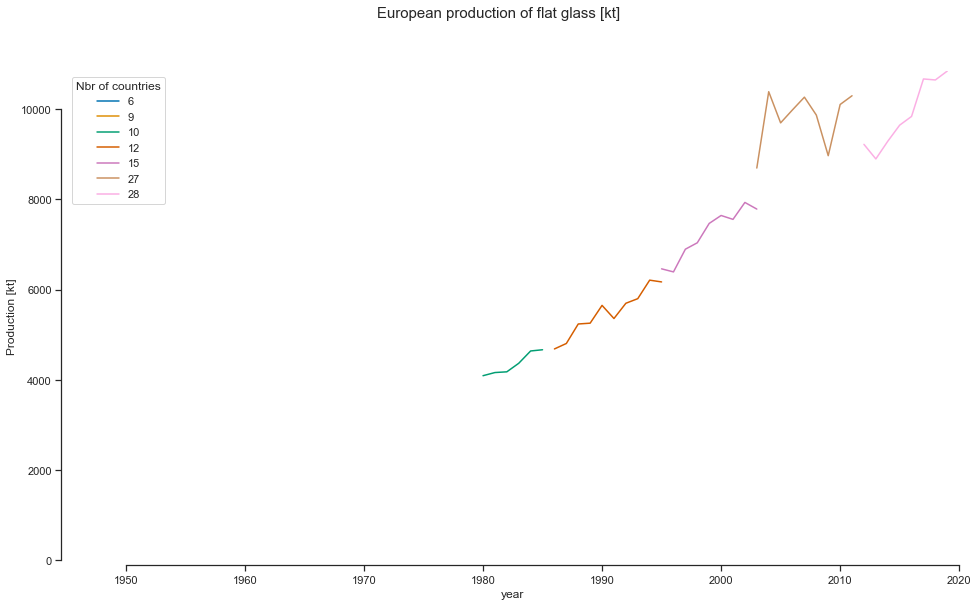

In [13]:
# Plot the European production of flat glass
fig, ax = plt.subplots()

sns.lineplot(data=EU.reset_index(),
             x='year', y='Production [kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)

fig.suptitle('European production of flat glass [kt]', fontsize=15)
sns.despine(offset=5, trim=True)
plt.show()

## Flat Glass Consumption

In [202]:
# Assess the consumption of flat glass in EU:
EU['Consumption [kt]'] = (EU['Production [kt]']
                          + EU['Import [kt]']
                          - EU['Export [kt]']
                          )

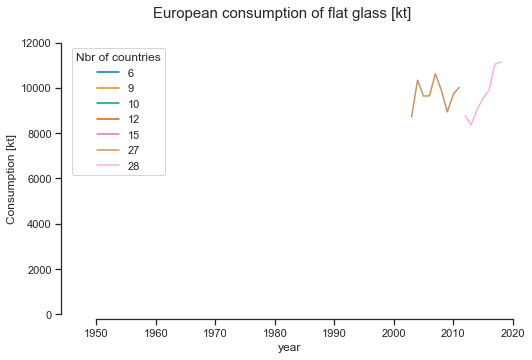

In [204]:
# Plot the European consumption of flat glass:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EU.reset_index(),
             x='year', y='Consumption [kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 12000)

fig.suptitle('European consumption of flat glass [kt]', fontsize=15)
sns.despine(offset=5, trim=True)
plt.show()

## Architectural Flat Glass Production

In [15]:
# Share of architectural glass in the European production of flat glass:
EUBldgShare = EU_Prod[['bldg glass/flat glass, %']].copy()
EUBldgShare = EUBldgShare.dropna()

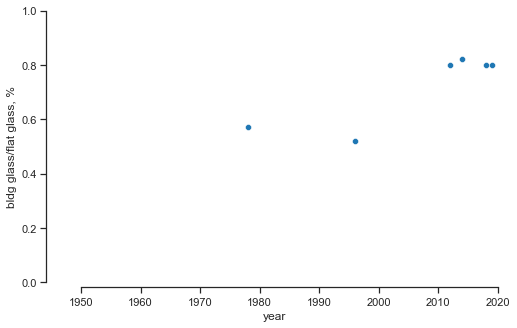

In [16]:
# Plot share of architectural glass/total flat glass:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=EUBldgShare.reset_index(),
                x='year', y='bldg glass/flat glass, %',
                markers="o", ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 1)

sns.despine(offset=5, trim=True)

In [17]:
# Linear interpolation according to available data:
EU['bldg glass/flat glass, %'] = (EU_Prod['bldg glass/flat glass, %']
                                  .interpolate(method="linear",
                                               limit_area='inside')
                                  )

In [18]:
# Calculation of the European production of architectural flat glass:
EU['Architectural glass production [kt]'] = (EU['Production [kt]']
                                             * EU['bldg glass/flat glass, %']
                                             )

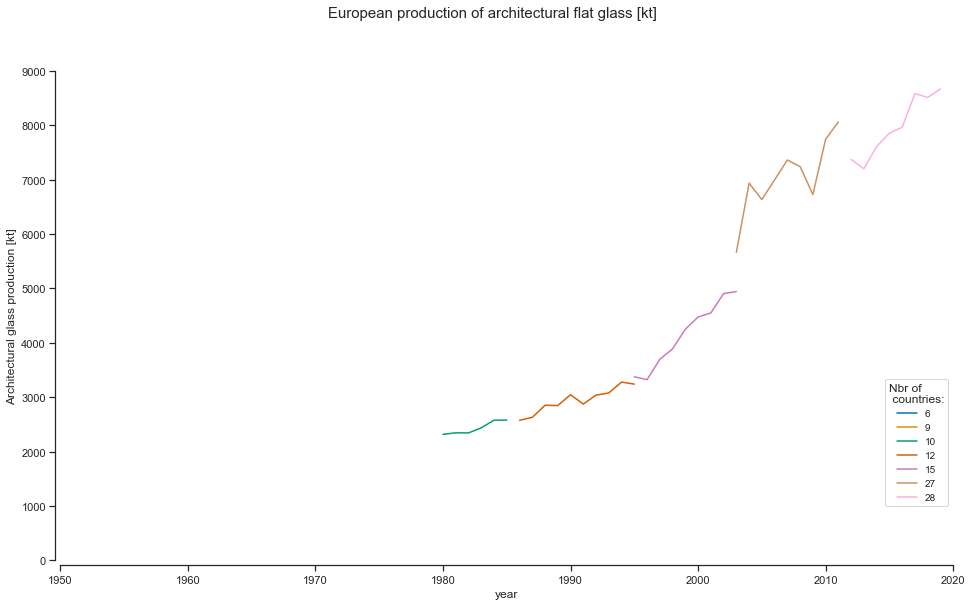

In [205]:
# Plot the European production of architectural flat glass:
fig, ax = plt.subplots()

sns.lineplot(data=EU.reset_index(),
             x='year', y='Architectural glass production [kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

# Add legend:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower right', ncol=1,
          fontsize='10', title='Nbr of \n countries:',
          bbox_to_anchor=(1, 0.1))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 9000)

fig.suptitle('European production of architectural flat glass [kt]',
             fontsize=15)
sns.despine(offset=5)
plt.show()

## Summary

In [206]:
# Assess the annual growth:
EU['Growth, flat glass [%]'] = EU['Production [kt]'].pct_change()
EU['Growth, arch glass [%]'] = (EU['Architectural glass production [kt]']
                                .pct_change())

In [207]:
# Growth of flat glass production in EU from 1980 to 1995:
a = (EU['Growth, flat glass [%]'].loc[10:12].mean()*100)
b = (EU['Growth, arch glass [%]'].loc[10:12].mean()*100)
print(f'Flat glass production growth in EU, 1980-1995:\n {a:.2f}%\n',
      f'Architectural glass production growth in EU, 1980-1995:\n {b:.2f}%')

# Growth of flat glass production in EU from 1995 to 2003:
c = (EU['Growth, flat glass [%]'].loc[12:15].mean()*100)
d = (EU['Growth, arch glass [%]'].loc[12:15].mean()*100)
print(f'Flat glass production growth in EU, 1995-2003:\n {c:.2f}%\n',
      f'Architectural glass production growth in EU, 1995-2003:\n {d:.2f}%')

# Growth of flat glass production in EU from 2003 to 2020:
e = (EU['Growth, arch glass [%]'].loc[27:28].mean()*100)
print(f'Flat glass production growth in EU, 2003-2020:\n {e:.2f}%')

Flat glass production growth in EU, 1980-1995:
 2.84%
 Architectural glass production growth in EU, 1980-1995:
 2.33%
Flat glass production growth in EU, 1995-2003:
 2.80%
 Architectural glass production growth in EU, 1995-2003:
 3.57%
Flat glass production growth in EU, 2003-2020:
 3.65%


In [22]:
# Function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

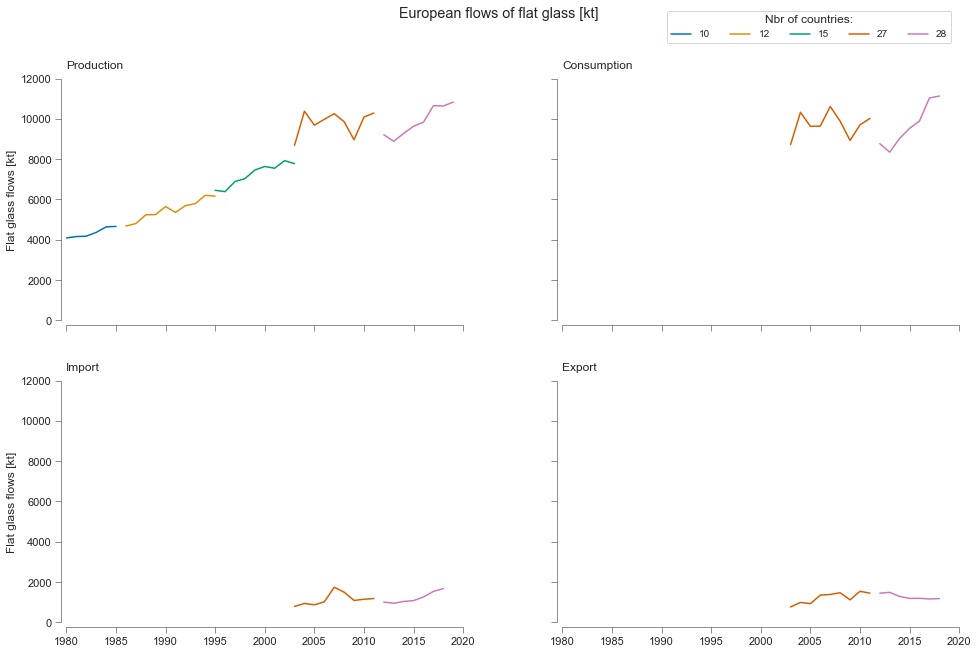

In [23]:
# Plot a synthesis of the results concerning European flat glass flows:
data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

# Plot production and consumption:
for col, data in enumerate(data1):
    ax = axes[0][col]
    sns.lineplot(data=EU.loc[10:28].reset_index(),
                 x='year', y=f"{data} [kt]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    if col == 0:
        ax.set_ylabel('Flat glass flows [kt]')
    style_ax(ax)
    ax.set_title(data, pad=10, loc='left')
    ax.get_legend().remove()

# Plot import and export below:
for col, data in enumerate(data2):
    ax = axes[1][col]
    sns.lineplot(data=EU.loc[10:28].reset_index(),
                 x='year', y=f"{data} [kt]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    if col == 0:
        ax.set_ylabel('Flat glass flows [kt]')
    style_ax(ax)
    ax.set_title(data, pad=10, loc='left')
    ax.get_legend().remove()

# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=7,
           fontsize='10', title='Nbr of countries:',
           bbox_to_anchor=(0.83, 0.9))

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 12000)

fig.suptitle("European flows of flat glass [kt]")
fig.subplots_adjust(wspace=0.25, hspace=0.25)

sns.despine(offset=5, trim=True)
plt.show()

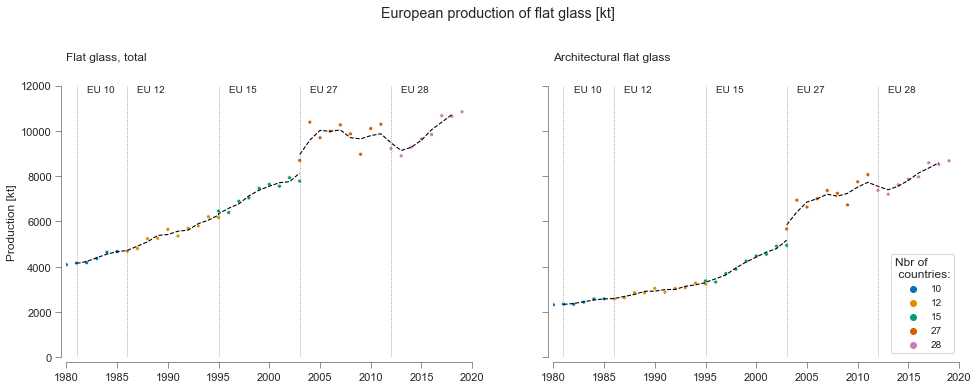

In [24]:
# Plot the European production of flat glass (total and only arch glass):
data = ['Production', 'Architectural glass production']

# Key dates for the changes in the MFA scope, i.e. EU enlargement:
EU_Kdates = {'EU 10': 1981, 'EU 12': 1986, 'EU 15': 1995,
             'EU 27': 2003, 'EU 28': 2012}

# Plot two figures:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

#Number of countries for trend curves:
a = [(10, 15), (27, 28)]

for col, data in enumerate(data):
    for i, j in a:
        ax = axes[col]
        # Plot the trend curve for flat glass production:
        ax.plot(EU.interpolate().rolling(3, center=True).mean().loc[i:j]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{data} [kt]"],
                linewidth=1.1, c='black', linestyle='--'
                )

    # Plot data gathered from literature review:
    sns.scatterplot(data=EU.loc[10:28].reset_index(),
                    x='year', y=f"{data} [kt]",
                    hue='Nbr of countries',
                    palette='colorblind',
                    marker='.', s=60,
                    ax=ax)
    if col == 0:
        ax.get_legend().remove()
        ax.set_title('Flat glass, total', pad=25, loc='left')
    else:
        ax.set_title('Architectural flat glass', pad=25, loc='left')
        # Add legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='upper right', ncol=1,
                  fontsize='10', title='Nbr of \n countries:',
                  bbox_to_anchor=(1, 0.4))

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_Kdates.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+1, 12000, f"{y}", fontsize=10,
                verticalalignment='top')

    style_ax(ax)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 12000)

fig.suptitle("European production of flat glass [kt]", y=1.10)
fig.subplots_adjust(wspace=0.2)

sns.despine(offset=5, trim=True)
plt.show()

# Save image:
# fig.savefig(os.path.join(path_img, 'European production of flat glass.png'),
#            dpi=600)
# fig.savefig(os.path.join(path_img, 'European production of flat glass.pdf'))

# Flat Glass Production in France and Belgium

## Creating a Dataframe for Flat Glass Flows

In [25]:
# Create a DataFrame with production data:
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

In [26]:
# Creating DataFrames with import and export data:
FR_Imp = FR_data.parse('import').set_index('year')
FR_Exp = FR_data.parse('export').set_index('year')

BE_Imp = BE_data.parse('import').set_index('year')
BE_Exp = BE_data.parse('export').set_index('year')

In [27]:
# Create a unique DataFrame for French and Belgian flat glass flows:
BE_FR = pd.concat([FR_Prod['flat glass, kt'], BE_Prod['flat glass, kt'],
                   FR_Imp['flat glass, kt'], BE_Imp['flat glass, kt'],
                   FR_Exp['flat glass, kt'], BE_Exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]', 'France'),
                                ('Production [kt]', 'Belgium'),
                                ('Import [kt]', 'France'),
                                ('Import [kt]', 'Belgium'),
                                ('Export [kt]', 'France'),
                                ('Export [kt]', 'Belgium')],
                  names=['Info', 'Country']).stack()

BE_FR = BE_FR.unstack()

In [28]:
# Overview of FR and BE dataframe for flat glass flows:
BE_FR

Info    Export [kt]         Import [kt]        Production [kt]       
Country     Belgium  France     Belgium France         Belgium France
year                                                                 
1945            NaN     NaN         NaN    NaN             NaN  108.3
1946            NaN     NaN         NaN    NaN             NaN  173.8
1947            NaN     NaN         NaN    NaN             NaN  198.3
1948            NaN     NaN         NaN    NaN             NaN  220.2
1949            NaN     NaN         NaN    NaN             NaN  191.3
...             ...     ...         ...    ...             ...    ...
2016         499.79  300.84      216.27  370.0             NaN    NaN
2017         547.19  333.31      230.96  401.0             NaN    NaN
2018         547.76  349.18      228.65  355.0             NaN    NaN
2019         986.33  451.42      254.22  352.0             NaN    NaN
2020            NaN     NaN         NaN  349.0             NaN    NaN

[76 rows x 6 columns]

## Production of flat glass

In [ ]:
countries = ['Belgium', 'France']

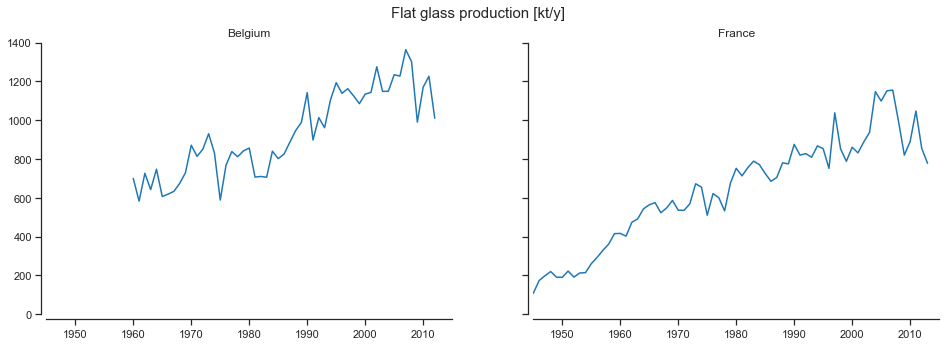

In [197]:
# Plot the flat glass production:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(BE_FR['Production [kt]'].index, 
            BE_FR['Production [kt]'][country])
    
    ax.set_title(country)
    ax.set_xlim(1945, 2015)
    ax.set_ylim(0, 1400)

fig.suptitle('Flat glass production [kt/y]', fontsize=15)
sns.despine(offset=5)
plt.show()

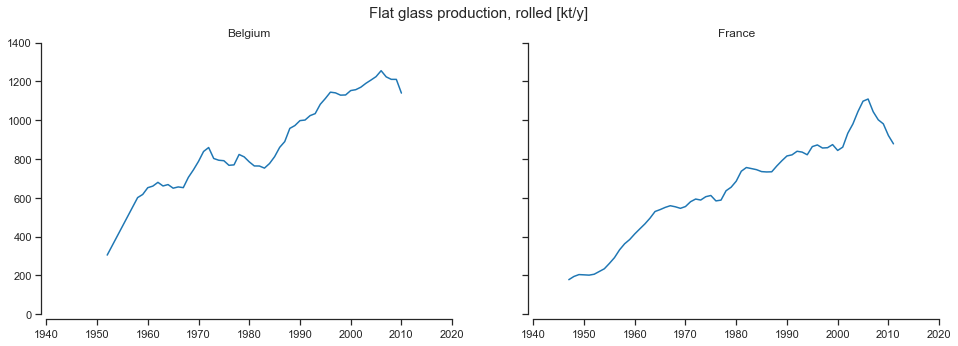

In [208]:
# Plot a moving average for flat glass production:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(BE_FR['Production [kt]'].index,
            BE_FR['Production [kt]'][country]
            # Linear interpolation for flat glass production:
            .interpolate(method="linear", limit_area='inside')
            # Rolling flat glass production according to a 5-year mean:
            .rolling(5, center=True).mean())
    
    ax.set_title(country)
    ax.set_xlim(1940, 2020)
    ax.set_ylim(0, 1400)

fig.suptitle('Flat glass production, rolled [kt/y]', fontsize=15)
sns.despine(offset=5)
plt.show()

## Consumption of flat glass

In [31]:
# Caculate import and export ratios relative to production:
BE_FR = BE_FR.stack()

BE_FR['Import Ratio'] = BE_FR['Import [kt]'] / BE_FR['Production [kt]']
BE_FR['Export Ratio'] = BE_FR['Export [kt]'] / BE_FR['Production [kt]']

BE_FR = BE_FR.unstack()

In [32]:
ratios = ['Import', 'Export']

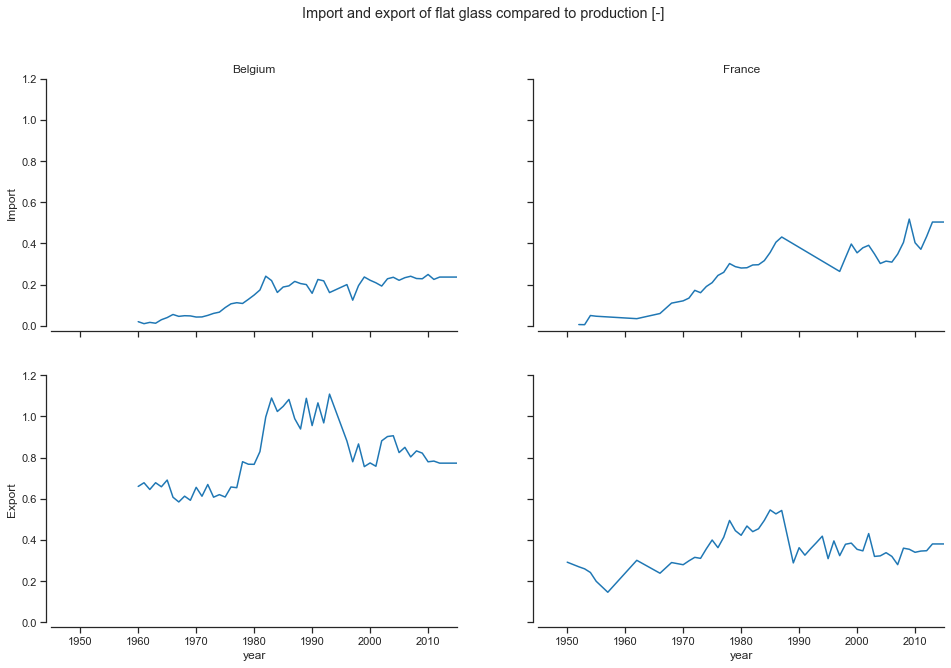

In [151]:
# Plot import and export ratios for FR and BE:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
            
        (BE_FR[(f"{ratio} Ratio", country)]
         .plot(ax=ax)
         )

ax.set_ylim(0, 1.2)
ax.set_xlim(1945, 2015)

fig.suptitle("Import and export of flat glass compared to production [%]")
sns.despine(offset=5)
plt.show()

In [34]:
# Interpolation for missing data:
cols = [x for x in BE_FR.columns if x[0] in ['Import Ratio', 'Export Ratio']]

BE_FR[cols] = (BE_FR[cols].interpolate(method='linear'))

In [35]:
BE_FR.loc[1950:1960, cols]

Info    Import Ratio           Export Ratio       
Country      Belgium    France      Belgium France
year                                              
1950             NaN       NaN          NaN   0.29
1951             NaN       NaN          NaN   0.28
1952             NaN  5.99e-03          NaN   0.27
1953             NaN  5.33e-03          NaN   0.26
1954             NaN  4.99e-02          NaN   0.24
1955             NaN  4.64e-02          NaN   0.20
1956             NaN  4.47e-02          NaN   0.17
1957             NaN  4.30e-02          NaN   0.15
1958             NaN  4.14e-02          NaN   0.18
1959             NaN  3.97e-02          NaN   0.21
1960            0.02  3.80e-02         0.66   0.24

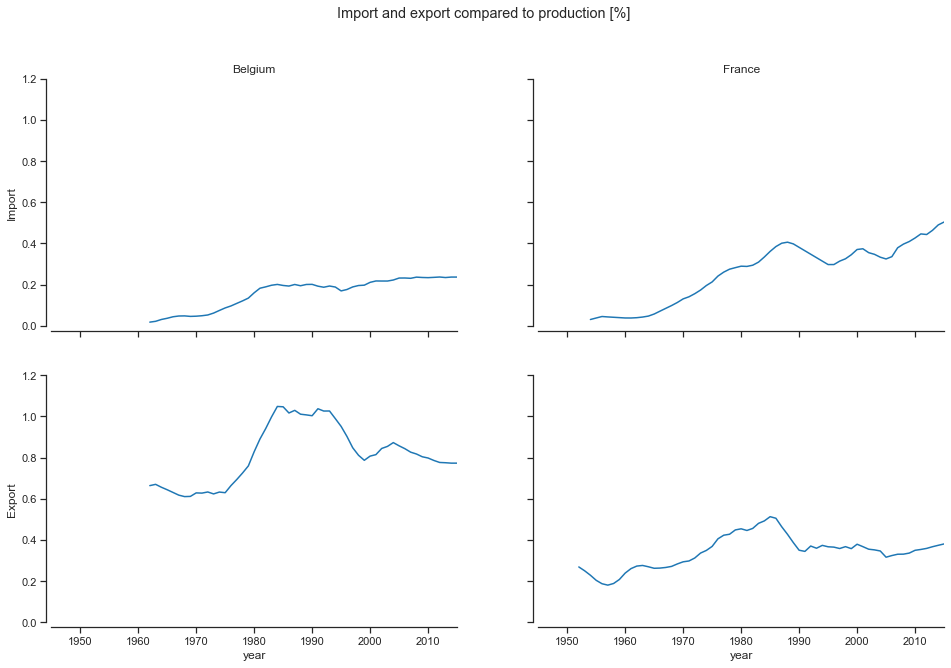

In [155]:
# Plot import and export ratios, moving average with a 5-y. window length:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
            
        (BE_FR[(f"{ratio} Ratio", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax)
         )

ax.set_xlim(1945, 2015)
ax.set_ylim(0, 1.2)

fig.suptitle("Import and export compared to production [%]")
sns.despine(offset=5)
plt.show()

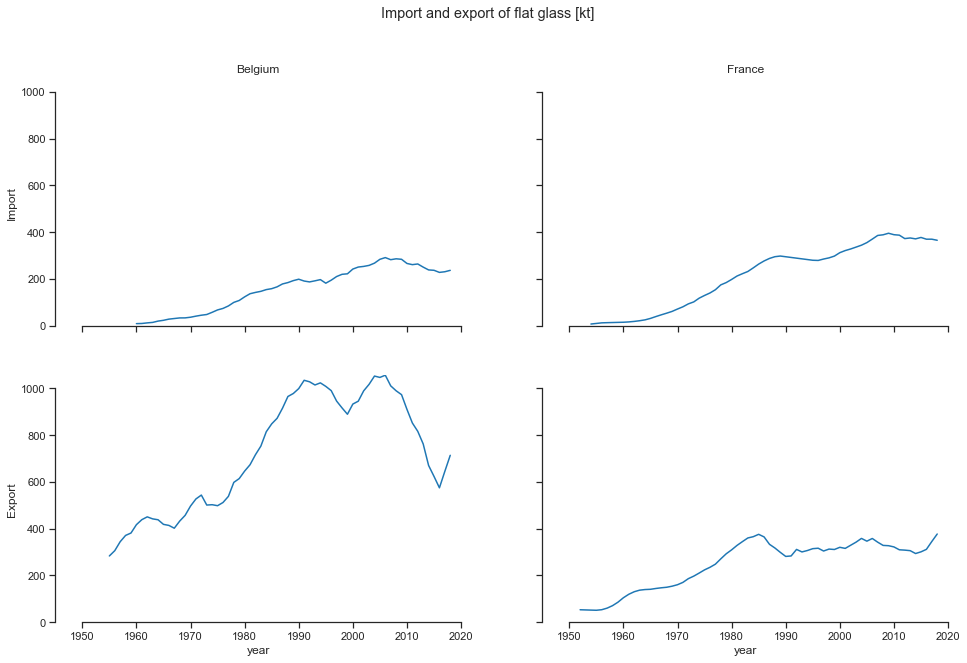

In [157]:
# Plot total import and export flows, moving average w/ a 5-y. window length:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))
for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR[(f"{ratio} [kt]", country)]
         .interpolate(method='linear')
         .rolling(5, center=True).mean()
         .plot(ax=ax)
         )

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)

fig.suptitle("Import and export of flat glass [kt]")
sns.despine(trim=True)
plt.show()

In [38]:
# Calulate total consumption of flat glass in BE and FR:
BE_FR = BE_FR.stack()

BE_FR['Consumption [kt]'] = (BE_FR['Production [kt]']
                             + BE_FR['Import Ratio']
                             * BE_FR['Production [kt]']
                             - BE_FR['Export Ratio']
                             * BE_FR['Production [kt]']
                             )

BE_FR = BE_FR.unstack()

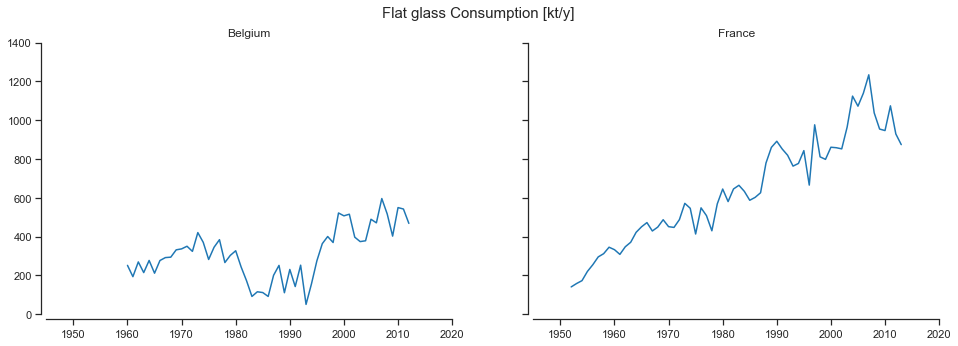

In [168]:
# Plot total consumption of flat glass:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(BE_FR['Consumption [kt]'].index,
            BE_FR['Consumption [kt]'][country])
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 1400)

fig.suptitle('Flat glass Consumption [kt/y]', fontsize=15)
sns.despine(offset=5)
plt.show()

In [40]:
# Create a DataFrame for the FR and BE demography:
FR_Pop = FR_data.parse('Population').set_index('year')
BE_Pop = BE_data.parse('Population').set_index('year')

In [41]:
# Create a single DataFrame for French and Belgian population since 1945:
BE_FR_Pop = pd.concat([FR_Pop['Population, x1000'],
                       BE_Pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

BE_FR_Pop = BE_FR_Pop.unstack()

In [42]:
# Linear interpolation for a few missing data (BE, from 1947 to 1959): 
BE_FR_Pop[('Population [x1000]', 'Belgium')] = (
    BE_FR_Pop[('Population [x1000]', 'Belgium')].interpolate(method='linear')
)

In [43]:
# Estimate the consumption per capita:
for country in BE_FR['Consumption [kt]'].columns:
    BE_FR[('Consumption [kg/cap]', country)] = (
        BE_FR[('Consumption [kt]', country)]
        / BE_FR_Pop[('Population [x1000]', country)] * 1000)

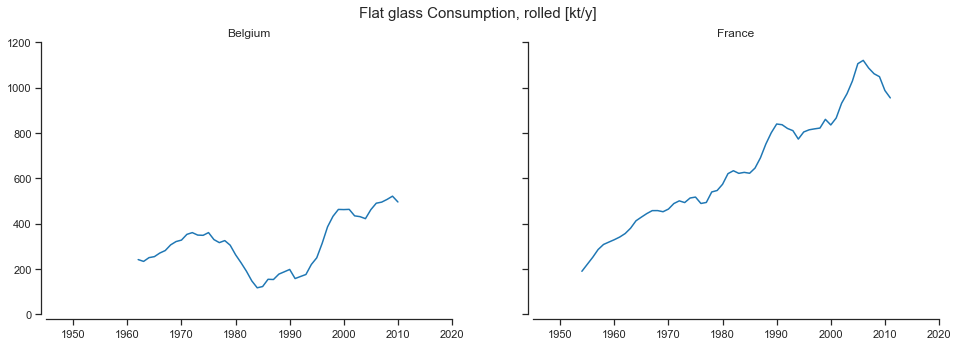

In [194]:
# Linear interpolation for flat glass consumption
# and moving average with a 5-year window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(BE_FR['Consumption [kt]'].index,
            BE_FR['Consumption [kt]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 1200)

fig.suptitle('Flat glass Consumption, rolled [kt/y]', fontsize=15)
sns.despine(offset=5)
plt.show()

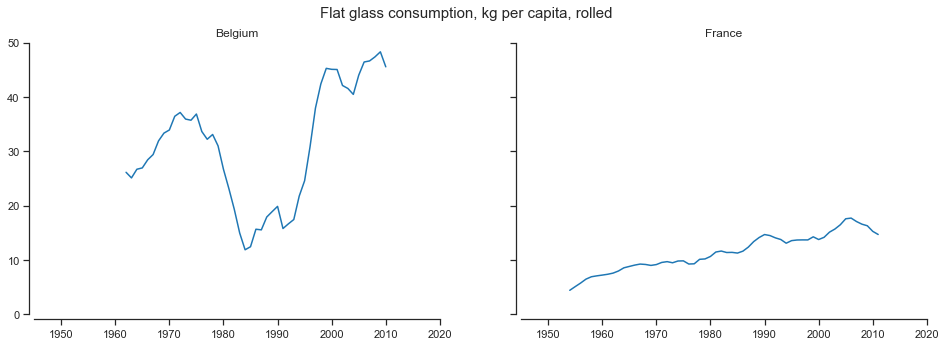

In [192]:
# Linear interpolation for flat glass consumption per capita
# and moving average with a 5-y. window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(BE_FR['Consumption [kg/cap]'].index,
            BE_FR['Consumption [kg/cap]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 50)

fig.suptitle('Flat glass consumption, kg per capita, rolled', fontsize=15)
sns.despine(offset=5)
plt.show()

## Production of architectural flat glass

In [46]:
# Share of building glass relative to the total flat glass production in FR:
ShareFR = FR_Prod[['bldg glass/flat glass, %']].dropna()

print(ShareFR.isnull().sum())
ShareFR

bldg glass/flat glass, %    0
dtype: int64


,"bldg glass/flat glass, %"
year,
1945,0.90
1952,0.80
1962,0.68
1968,0.50
1980,0.50
1994,0.50
2002,0.52
2004,0.49
2009,0.52


In [47]:
# Calculate the main parameters of a regression curve, second order
# to interpolate "arch glass/total flat glass" ratio, with uncertainties:
ShareFR['Trend'] = FR_Prod[['bldg glass/flat glass, %']].copy()

ShareFR = ShareFR.reset_index()

x = np.array(list(ShareFR['year']))
y = np.array(list(ShareFR['Trend']))

ShareFR = ShareFR.set_index('year')

# Order of the regression:
n = 3

# Polynomial coefficients and covariance matrix:
coeffs, cov = np.polyfit(x, y, n, cov=True)

results = {}
results['Polynomial'] = coeffs.tolist()
results['Covariance'] = cov.tolist()

# Interpolation:
t = np.linspace(1945, 2020, 76)

# Matrix with rows 1, t, t**2...:
TT = np.vstack([t**(n-i) for i in range(1+n)]).T

# Matrix multiplication for the polynomial values:
z = np.dot(TT, coeffs)

# Standard deviations (sqrt of diagonal):
sig = np.sqrt(
    np.diag(
        np.dot(TT, np.dot(cov, TT.T))
    ))

# r-squared
p = np.poly1d(coeffs)

# fit values, and mean
yhat = p(x)                      # vector y = p(z) for z in x
ybar = np.sum(y)/len(y)          # mean of y data
SSres = np.sum((yhat-ybar)**2)   # residual sum of squares
SStot = np.sum((y - ybar)**2)    # total sum squares

results['Coefficient of determination'] = SSres / SStot

results

{'Polynomial': [-2.378960893414362e-06,
  0.014301359629274039,
  -28.656983590865888,
  19140.70797173813],
 'Covariance': [[2.8029866613415203e-12,
   -1.6645777335936083e-08,
   3.2948302953039774e-05,
   -0.021737417444942602],
  [-1.6645777335958778e-08,
   9.88533429177357e-05,
   -0.19567014611392025,
   129.09330281953902],
  [3.294830295312971e-05,
   -0.1956701461141876,
   387.3129582861321,
   -255532.078955934],
  [-0.021737417445031697,
   129.09330281989222,
   -255532.0789562839,
   168590499.05965033]],
 'Coefficient of determination': 0.9311453347637837}

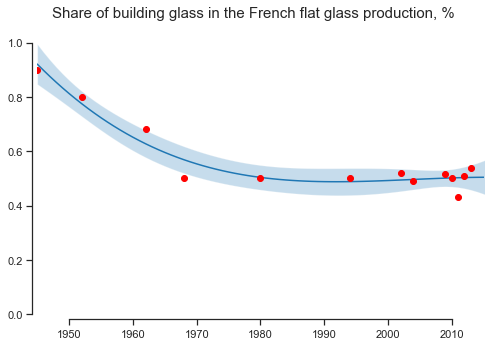

In [48]:
# Scatterplot of the ratio and plot the regression curve, order 2:
fig, ax = plt.subplots(figsize=(8, 5))

ax.fill_between(t, z+1.96*sig, z-1.96*sig, alpha=0.25)
ax.plot(t, z, '-')
ax.plot(x, y, 'ro')

ax.set_ylim(0, 1)
ax.set_xlim(1945, 2015)

fig.suptitle('Share of building glass in the French flat glass production, %',
             fontsize=15)
sns.despine(offset=5, trim=True)
plt.show()

In [50]:
# Create a dataframe for ratio arch glass/tot flat glass:
BldgShare = FR_Prod[['bldg glass/flat glass, %']].copy()

# Interpolate values according to
# nonlinear regression previously estimated
BldgShare['Mean ratio arch glass/flat glass, %'] = z.tolist()

# Integrate standard deviation in FR_Prod
BldgShare['std for ratio arch glass/flat glass'] = sig.tolist()

BldgShare

,"bldg glass/flat glass, %","Mean ratio arch glass/flat glass, %",std for ratio arch glass/flat glass
year,,,
1945,0.9,0.92,0.04
1946,NaN,0.90,0.03
1947,NaN,0.87,0.03
1948,NaN,0.85,0.03
1949,NaN,0.83,0.03
...,...,...,...
2016,NaN,0.50,0.04
2017,NaN,0.50,0.04
2018,NaN,0.50,0.05


In [51]:
# Estimate architectural flat glass production in FR and BE:
for country in countries:
    BE_FR[('Architectural glass production [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * BldgShare['Mean ratio arch glass/flat glass, %']
    )

for country in countries:
    BE_FR[('std for architectural glass production', country)] = (
        BE_FR[('Production [kt]', country)]
        * BldgShare['std for ratio arch glass/flat glass']
    )

In [190]:
# Calculate data for uncertainties according to the standard deviaton, 95%:
x = np.array(BE_FR['Architectural glass production [kt]'].index)

yminFR = np.array(BE_FR[('Architectural glass production [kt]', 'France')]
                  + 1.96
                  * BE_FR[('std for architectural glass production', 'France')])
ymaxFR = np.array(BE_FR[('Architectural glass production [kt]', 'France')]
                  - 1.96
                  * BE_FR[('std for architectural glass production', 'France')])

yminBE = np.array(BE_FR[('Architectural glass production [kt]', 'Belgium')]
                  + 1.96
                  * BE_FR[('std for architectural glass production', 'Belgium')])
ymaxBE = np.array(BE_FR[('Architectural glass production [kt]', 'Belgium')]
                  - 1.96
                  * BE_FR[('std for architectural glass production', 'Belgium')])

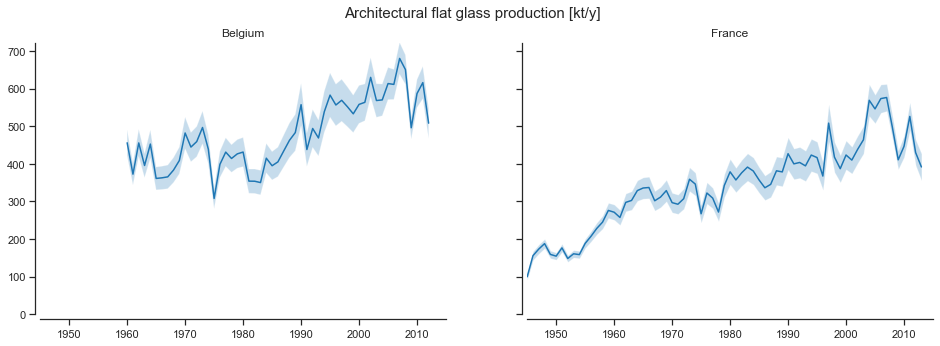

In [191]:
# Plot architectural flat glass production with uncertainties (95%):
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(BE_FR['Architectural glass production [kt]'].index,
            BE_FR['Architectural glass production [kt]'][country])
    
    if country == 'France':
        ax.fill_between(x, yminFR, ymaxFR, alpha=0.25)
    elif country == 'Belgium':
        ax.fill_between(x, yminBE, ymaxBE, alpha=0.25)
        
    ax.set_title(country)
    ax.set_xlim(1945, 2015)
    ax.set_ylim(ymin=0)

fig.suptitle('Architectural flat glass production [kt/y]', fontsize=15)
sns.despine(offset=5)
plt.show()

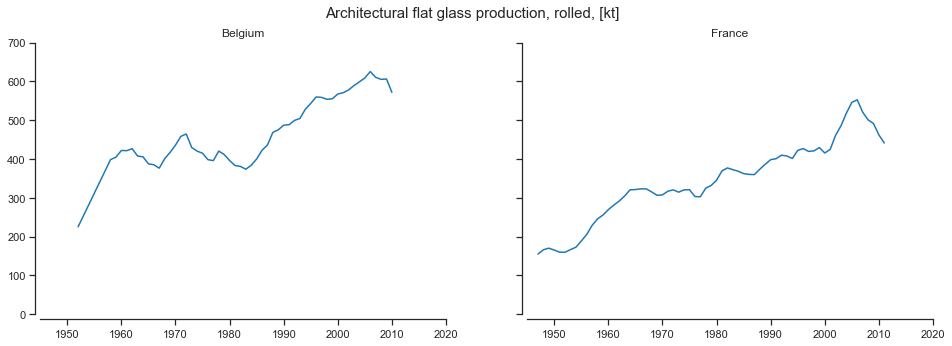

In [188]:
# Plot architectural flat glass prod, with a moving average, no uncertainty:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(BE_FR['Architectural glass production [kt]'].index,
            BE_FR['Architectural glass production [kt]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())
    
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 700)

fig.suptitle('Architectural flat glass production, rolled, [kt]', fontsize=15)
sns.despine(offset=5)
plt.show()

In [185]:
# Calculate data for uncertainties according to the standard deviaton, 95%,
# and undertake a moving average with a 5-y. window length:
yminFR = np.array((BE_FR[('Architectural glass production [kt]', 'France')]
                   .rolling(5, center=True).mean())
                  + 1.96*BE_FR[('std for architectural glass production',
                                'France')]
                  )
ymaxFR = np.array((BE_FR[('Architectural glass production [kt]', 'France')]
                   .rolling(5, center=True).mean())
                  - 1.96*BE_FR[('std for architectural glass production',
                                'France')]
                  )

yminBE = np.array((BE_FR[('Architectural glass production [kt]', 'Belgium')]
                   .rolling(5, center=True).mean())
                  + 1.96*BE_FR[('std for architectural glass production',
                                'Belgium')]
                  )
ymaxBE = np.array((BE_FR[('Architectural glass production [kt]', 'Belgium')]
                   .rolling(5, center=True).mean())
                  - 1.96*BE_FR[('std for architectural glass production',
                                'Belgium')]
                  )

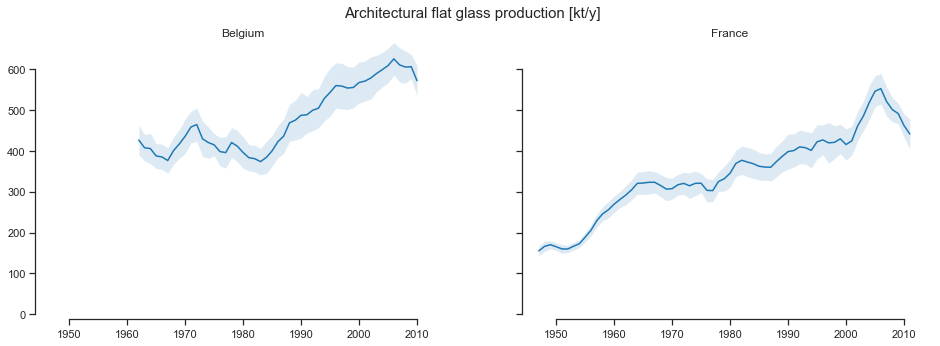

In [187]:
# Plot architectural flat glass prod, with a moving average, w/ uncertainties:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(BE_FR['Architectural glass production [kt]'].index,
            (BE_FR['Architectural glass production [kt]'][country]
             .rolling(5, center=True).mean())
            )
    if country == 'France':
        ax.fill_between(x, yminFR, ymaxFR, alpha=0.15)
    elif country == 'Belgium':
        ax.fill_between(x, yminBE, ymaxBE, alpha=0.15)

    ax.set_title(country)
    ax.set_xlim(1945, 2015)
    ax.set_ylim(ymin=0)

fig.suptitle('Architectural flat glass production [kt/y]', fontsize=15)
sns.despine(offset=5, trim=True)
plt.show()

## Consumption of architectural flat glass

In [57]:
# Calculate Belgian and French consumption of architectural flat glass:
BE_FR = BE_FR.stack()

BE_FR['Architectural glass consumption [kt]'] = (
    BE_FR['Architectural glass production [kt]']
    + BE_FR['Import Ratio'] * BE_FR['Architectural glass production [kt]']
    - BE_FR['Export Ratio'] * BE_FR['Architectural glass production [kt]']
)

BE_FR = BE_FR.unstack()

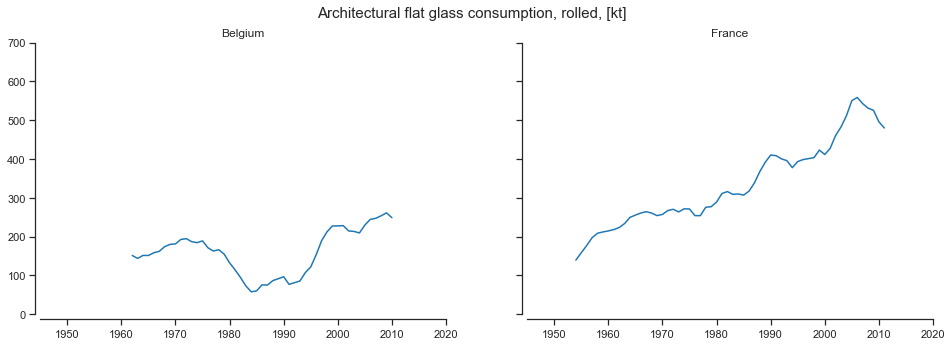

In [183]:
# Interpolate and undertake a mean average for architectural glass consumption
# and plot:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(),countries)):

    ax.plot(BE_FR['Architectural glass consumption [kt]'].index,
            BE_FR['Architectural glass consumption [kt]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 700)

fig.suptitle('Architectural flat glass consumption, rolled, [kt]',
             fontsize=15)
sns.despine(offset=5)
plt.show()

In [198]:
# Estimate the consumption per capita:
for country in countries:
    BE_FR[('Architectural glass consumption [kg/cap]',
           country)] = (
        BE_FR[('Architectural glass consumption [kt]', country)]
        / BE_FR_Pop[('Population [x1000]', country)] * 1000)

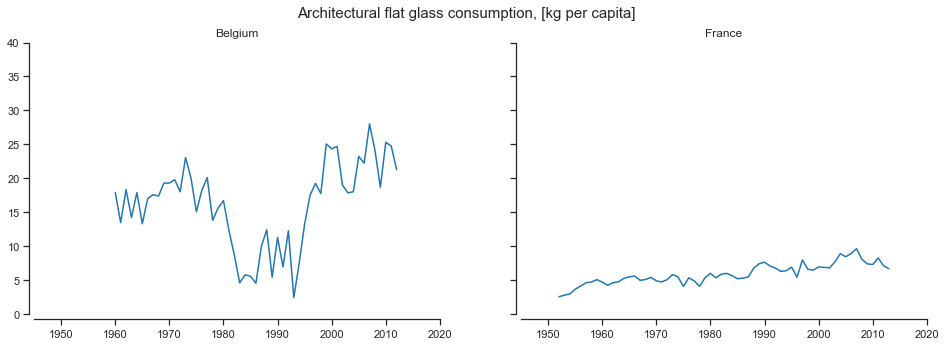

In [215]:
# Plot architectural glass consumption per capita:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(),
                                      countries)):

    ax.plot(BE_FR['Architectural glass consumption [kg/cap]'].index,
            BE_FR['Architectural glass consumption [kg/cap]'][country]
            )

    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 40)

fig.suptitle('Architectural flat glass consumption, [kg per capita]',
             fontsize=15)
sns.despine(offset=5)
plt.show()

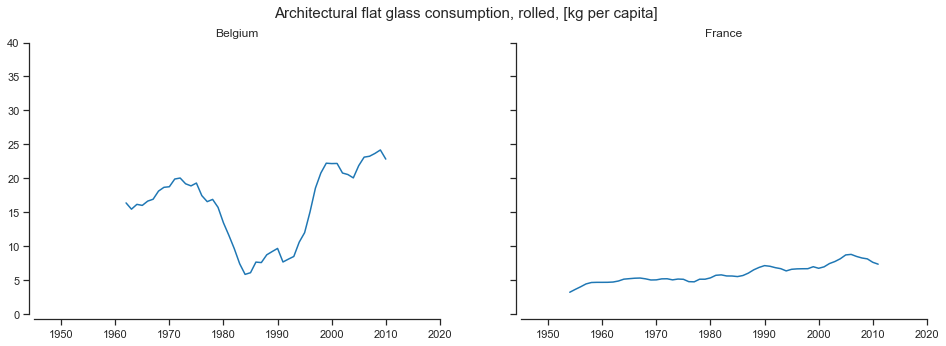

In [214]:
# Interpolation and moving average for architectural glass consuption / cap
# and plot:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(),
                                      countries)):

    ax.plot(BE_FR['Architectural glass consumption [kg/cap]'].index,
            BE_FR['Architectural glass consumption [kg/cap]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())
    ax.set_title(country)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 40)

fig.suptitle('Architectural flat glass consumption, rolled, [kg per capita]',
             fontsize=15)
sns.despine(offset=5)
plt.show()

## Summary

In [62]:
# Calculate annual growth:
for country in countries:
    BE_FR[('Growth, flat glass [%]',
           country)] = (BE_FR[('Production [kt]',
                               country)].pct_change()
                        )
    BE_FR[('Growth, arch glass [%]',
           country)] = (BE_FR[('Architectural glass production [kt]',
                               country)].pct_change()
                        )
    BE_FR[('Growth, arch glass consumption [%]',
           country)] = (BE_FR[('Architectural glass consumption [kt]',
                               country)].pct_change()
                        )

In [63]:
# Growth of the production in FR from 1950 to 1965:
a = BE_FR[('Growth, flat glass [%]', 'France')].loc[1951:1965].mean()*100
b = BE_FR[('Growth, arch glass [%]', 'France')].loc[1951:1965].mean()*100
print(f'Flat glass production growth in FR, 1950-1965:\n {a:.2f}%\n',
      f'Architectural glass production growth in FR, 1950-1965:\n {b:.2f}%')

# Growth of the production in FR from 1965 to 2000:
c = BE_FR[('Growth, flat glass [%]', 'France')].loc[1966:2000].mean()*100
d = BE_FR[('Growth, arch glass [%]', 'France')].loc[1966:2000].mean()*100
print(f'Flat glass production growth in FR, 1965-2000:\n {c:.2f}%\n ',
      f'Architectural glass production growth in FR, 1965-2000:\n {d:.2f}%')

# Growth of the consumption in FR from 1955 to 2000:
e = BE_FR[('Growth, arch glass consumption [%]', 'France')
          ].loc[1956:2000].mean()*100
print(f'Architectural glass consumption growth in FR, 1955-2000:\n {e:.2f}%')

Flat glass production growth in FR, 1950-1965:
 7.90%
 Architectural glass production growth in FR, 1950-1965:
 5.69%
Flat glass production growth in FR, 1965-2000:
 1.89%
  Architectural glass production growth in FR, 1965-2000:
 1.34%
Architectural glass consumption growth in FR, 1955-2000:
 3.05%


In [64]:
# Growth of the production in BE from 1985 to 2005:
a = BE_FR[('Growth, flat glass [%]', 'Belgium')].loc[1986:2005].mean()*100
b = BE_FR[('Growth, arch glass [%]', 'Belgium')].loc[1986:2005].mean()*100
print(f'Flat glass production growth in BE, 1985-2005:\n {a:.2f}%\n ',
      f'Architectural glass production growth in FR, 1985-2005:\n {d:.2f}')

Flat glass production growth in BE, 1985-2005:
 2.57%
  Architectural glass production growth in FR, 1985-2005:
 1.34


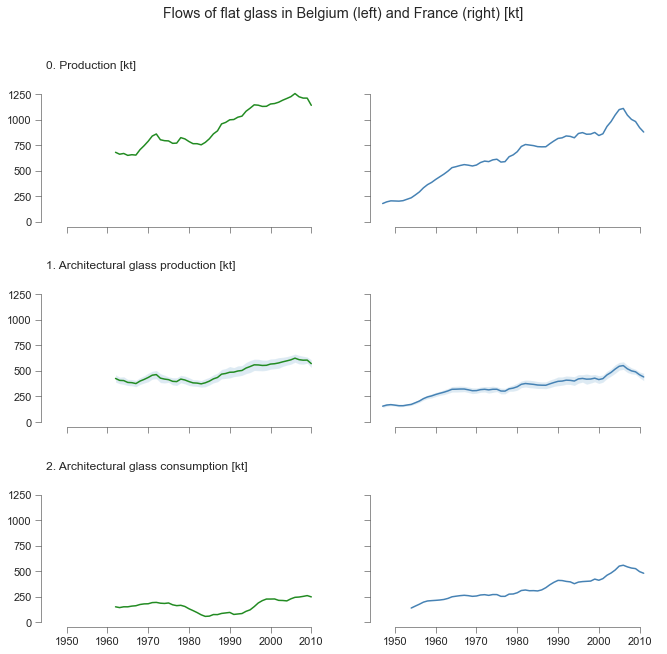

In [65]:
toplot = ['Production',
          'Architectural glass production',
          'Architectural glass consumption']

nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(11, 10))

for row, plot in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'forestgreen'
            ax.set_title(f"{row}. {plot} [kt]", pad=10, loc='left')
            if plot == 'Architectural glass production':
                ax.fill_between(x, yminBE, ymaxBE, alpha=0.15)
        else:
            color = 'steelblue'
            if plot == 'Architectural glass production':
                ax.fill_between(x, yminFR, ymaxFR, alpha=0.15)

        # Plot the 5-year rolled data:
        (BE_FR[(f"{plot} [kt]", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )
        style_ax(ax)

ax.set_xlim(1945, 2015)
ax.set_ylim(0, 1400)

fig.suptitle("Flows of flat glass in Belgium (left) and France (right) [kt]")
fig.subplots_adjust(wspace=0.15, hspace=0.4)

sns.despine(offset=5, trim=True)
plt.show()

# Save image
# fig.savefig(os.path.join(path_img, 'Flows of flat glass in BE and FR.png'),
#            dpi=600)
# fig.savefig(os.path.join(path_img, 'Flows of flat glass in BE and FR.pdf'))

# Material, Energy and Carbon Intensity in the Flat Glass Industry

## Material intensity since 1945

In [66]:
# Creating a DataFrame for material intensity
MatIntensity = FR_data.parse('RawMat_Intensity').set_index('year')

In [67]:
MatIntensity['cullet, kg/kg'] = (MatIntensity['internal cullet, kg/kg']
                                 + MatIntensity['external cullet, kg/kg'])

In [68]:
# Interpolating the raw material intensity dataset
MatIntensity = MatIntensity.interpolate(method='pchip',
                                        limit_direction='forward')

In [69]:
materials = ['cullet', 'sand', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

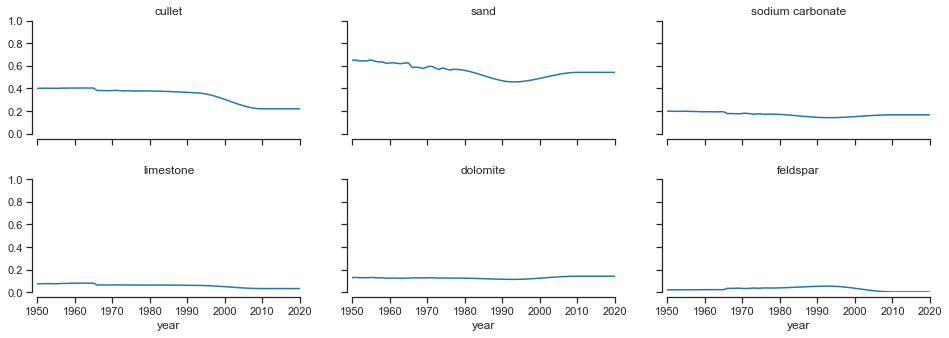

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    MatIntensity[(f"{mat}, kg/kg")].plot(ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5, trim=True)
plt.show()

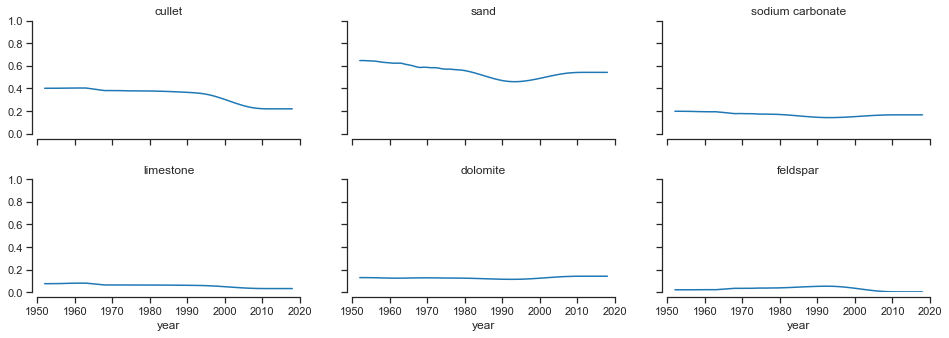

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    (MatIntensity[(f"{mat}, kg/kg")]
     .rolling(5, center=True).mean()
     .plot(ax=ax)
     )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5, trim=True)
plt.show()

In [72]:
MatIntensity['Total raw materials, kg/kg'] = 0

for mat in materials:
    MatIntensity['Total raw materials, kg/kg'] = (
        MatIntensity[(f"{mat}, kg/kg")]
        + MatIntensity['Total raw materials, kg/kg']
    )

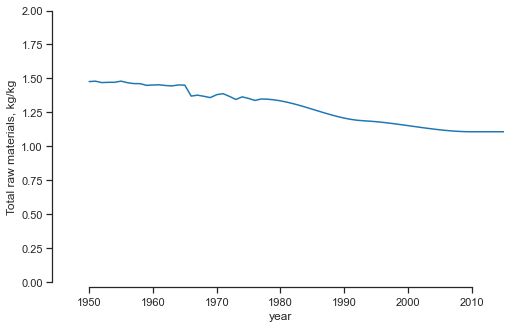

In [73]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=MatIntensity,
             x=MatIntensity.index,
             y='Total raw materials, kg/kg',
             ax=ax)

ax.set_xlim(1945, 2015)
ax.set_ylim(0, 2)
sns.despine(offset=5, trim=True)
plt.show()

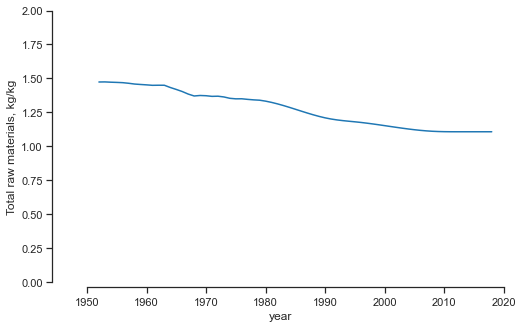

In [74]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=MatIntensity,
             x=MatIntensity.index,
             y=(MatIntensity['Total raw materials, kg/kg']
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 2)
sns.despine(offset=5, trim=True)
plt.show()

## Energy intensity since 1945

In [75]:
# Creating a DataFrame for energy intensity
EnergyIntensity = FR_data.parse('Energy_Intensity').set_index('year')

In [76]:
# Interpolating the raw material intensity dataset
EnergyIntensity = EnergyIntensity.interpolate(method='pchip',
                                              limit_direction='forward')

In [77]:
energies = ['fuel', 'natural gas', 'electricity']

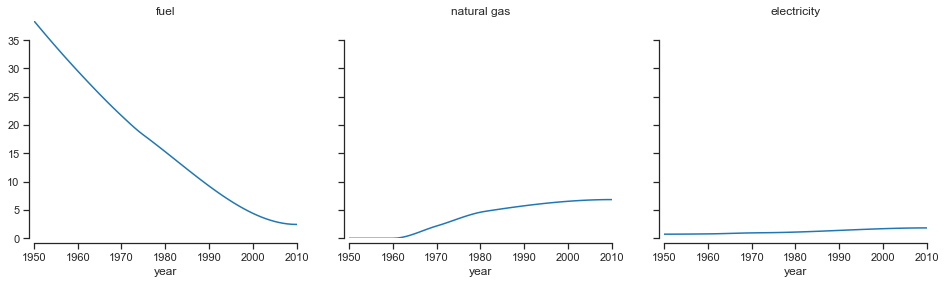

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, GJ/t")].plot(ax=ax)

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)
sns.despine(offset=5, trim=True)
plt.show()

In [79]:
EnergyIntensity['Total energy, GJ/t'] = 0

for energy in energies:

    EnergyIntensity['Total energy, GJ/t'] = (
        EnergyIntensity['Total energy, GJ/t']
        + EnergyIntensity[(f"{energy}, GJ/t")]
    )

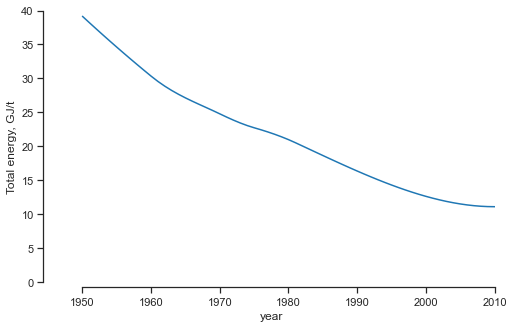

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EnergyIntensity,
             x=EnergyIntensity.index,
             y='Total energy, GJ/t',
             ax=ax)

ax.set_xlim(1945, 2010)
ax.set_ylim(0, 40)
sns.despine(offset=5, trim=True)
plt.show()

In [81]:
for energy in energies:
    EnergyIntensity[(f"{energy}, %")] = 0

    for energy in energies:
        EnergyIntensity[(f"{energy}, %")] = (
            EnergyIntensity[(f"{energy}, GJ/t")]
            / EnergyIntensity['Total energy, GJ/t']
        )

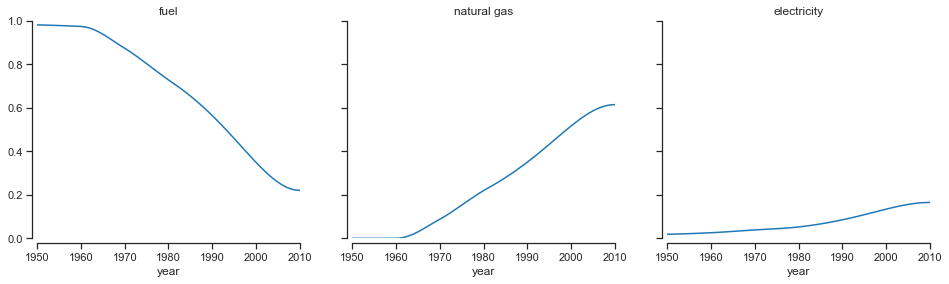

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, %")].plot(ax=ax)

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 1)
sns.despine(offset=5, trim=True)
plt.show()

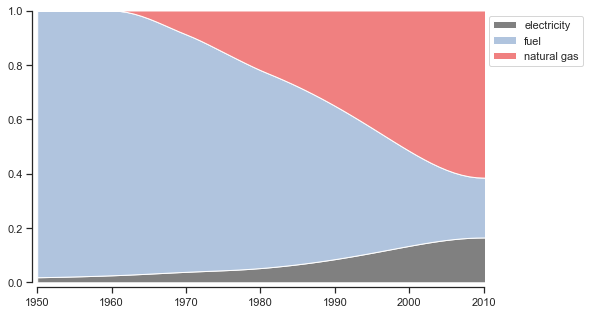

In [83]:
fig, ax = plt.subplots(figsize=(8, 5))

y = np.array([EnergyIntensity['electricity, %'].dropna(),
              EnergyIntensity['fuel, %'].dropna(),
              EnergyIntensity['natural gas, %'].dropna()]
             )

x = range(1950, 2021)

plt.stackplot(x, y,
              labels=['electricity', 'fuel', 'natural gas'],
              colors=["grey", "lightsteelblue", "lightcoral"])
plt.legend(loc='upper left')

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(offset=5, trim=True)
plt.show()

## Carbon Intensity of the Flat Glass Production Process

In [84]:
# Creating a DataFrame only with CO2 emission data
Emissions = FR_data.parse('emissions').set_index('year')

CO2_Intensity = Emissions[['CO2 glass ind, kg/t']].copy()
CO2_Intensity.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                     inplace=True)

CO2_Intensity.dropna()

,CO2 [kg/t]
year,
1947,2100.0
1950,2050.0
1960,1725.0
1965,1525.0
1970,1340.0
1975,1075.0
1980,900.0
1985,800.0
1990,690.0


In [85]:
CO2_Intensity['CO2 interpolated [kg/t]'] = (
    CO2_Intensity['CO2 [kg/t]'].interpolate('pchip')
)

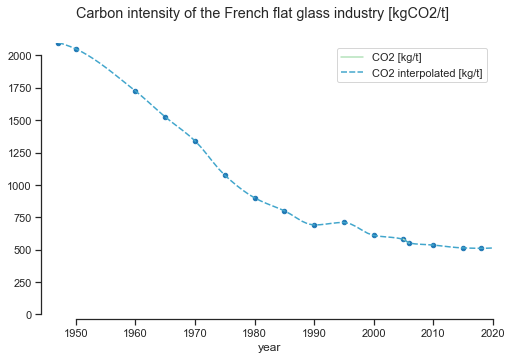

In [86]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=CO2_Intensity, palette="GnBu")

ax.scatter(x=CO2_Intensity.index, y=CO2_Intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
fig.suptitle("Carbon intensity of the French flat glass industry [kgCO2/t]")
sns.despine(offset=5, trim=True)
plt.show()

## Summary

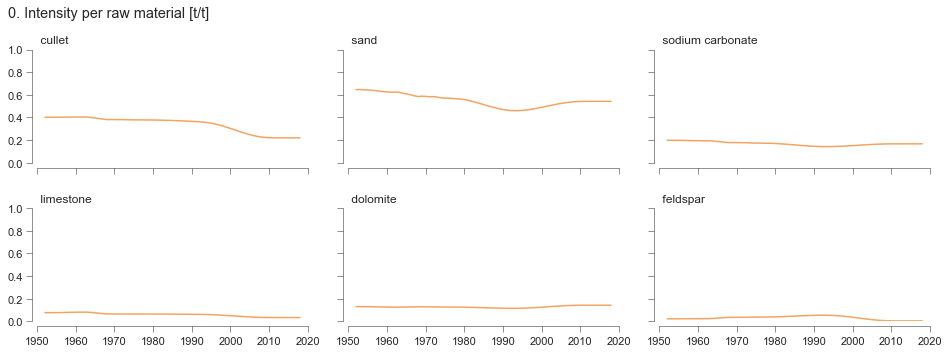

In [87]:
# Plot the material instensity per raw material:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    (MatIntensity[(f"{mat}, kg/kg")]
     .rolling(5, center=True).mean()
     .plot(ax=ax, c='sandybrown')
     )
    ax.set_title(f" {mat}", loc='left')
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("0. Intensity per raw material [t/t]", x=0.1, y=1, ha='left')
fig.subplots_adjust(wspace=0.15, hspace=0.4)
sns.despine(offset=5)

#fig.savefig(os.path.join(path_img, 'Mat Intensity.png'), dpi=600)

plt.show()

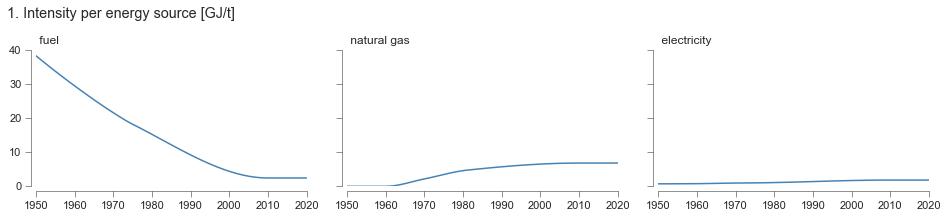

In [88]:
# Plot the energy intensity per source of energy:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    EnergyIntensity[(f"{energy}, GJ/t")].plot(ax=ax, color='steelblue')
    ax.set_title(f" {energy}", loc='left')
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("1. Intensity per energy source [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)
sns.despine(offset=5)

fig.savefig(os.path.join(path_img, 'Energy Intensity.png'), dpi=600)

plt.show()

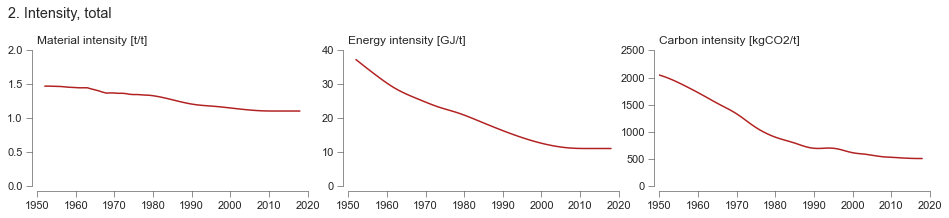

In [89]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Material intensity
ax = axes[0]
(MatIntensity['Total raw materials, kg/kg'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick')
 )
ax.set_title("Material intensity [t/t]", loc='left')
style_ax(ax)
ax.set_ylim(0, 2)
ax.set_xlim(1950, 2020)

# Energy intensity
ax = axes[1]
(EnergyIntensity['Total energy, GJ/t'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick')
 )
ax.set_title("Energy intensity [GJ/t]", loc='left')
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon intensity
ax = axes[2]
(CO2_Intensity['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick')
 )
ax.set_title("Carbon intensity [kgCO2/t]", loc='left')
style_ax(ax)
ax.set_ylim(0, 2500)

fig.suptitle("2. Intensity, total", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.15)
sns.despine(offset=5)

# plt.savefig(os.path.join(path_img, 'CO2 Intensity.png'), dpi=600)

plt.show()

# Raw Material and Energy Use in the European Flat Glass Industry

## Use of raw materials in the production of flat glass

In [90]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    EU[f"{mat}, flat glass [kt]"] = (
        EU['Production [kt]']
        * MatIntensity[(f"{mat}, kg/kg")]
    )

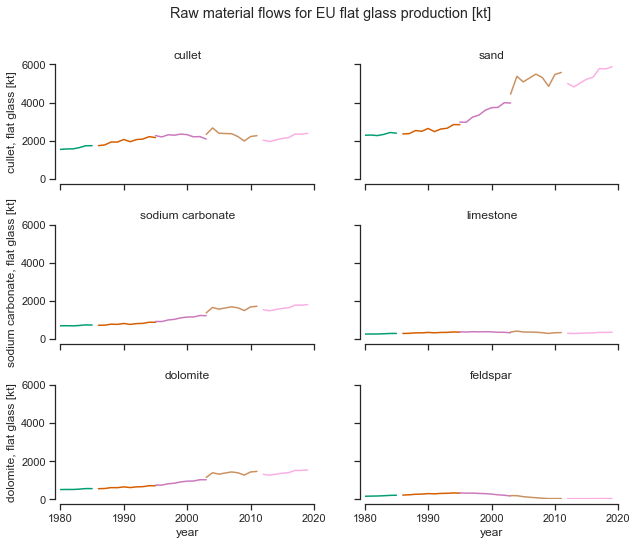

In [91]:
# Plot raw material flows for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{material}, flat glass [kt]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(material)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 6000)
    ax.get_legend().remove()

fig.suptitle("Raw material flows for EU flat glass production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

In [92]:
EU['Total raw materials, flat glass [Mt]'] = 0

for material in materials:
    EU['Total raw materials, flat glass [Mt]'] = (
        EU[f"{material}, flat glass [kt]"]/1000
        + EU['Total raw materials, flat glass [Mt]']
    )

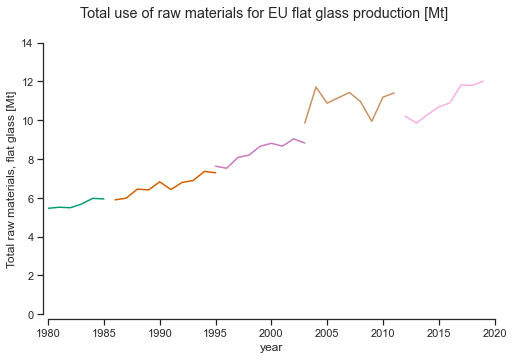

In [93]:
# Plot total material flows for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, flat glass [Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 14)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

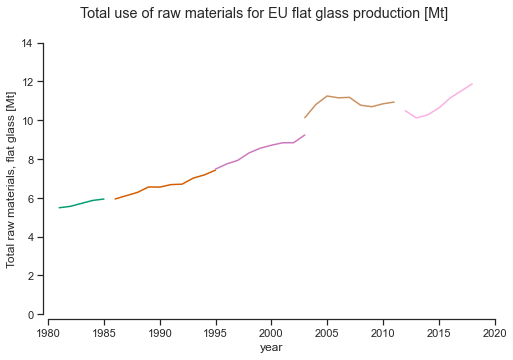

In [94]:
# Plot total material flows for EU flat glass production

EUplot = EU.rolling(3, center=True).mean().reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, flat glass [Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 14)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## Energy Use in the production of flat glass

In [95]:
# Absolute use of energy for flat glass production:
for energy in energies:
    EU[f"{energy}, flat glass [PJ]"] = (
        EU['Production [kt]']
        * EnergyIntensity[(f"{energy}, GJ/t")]/1000
    )

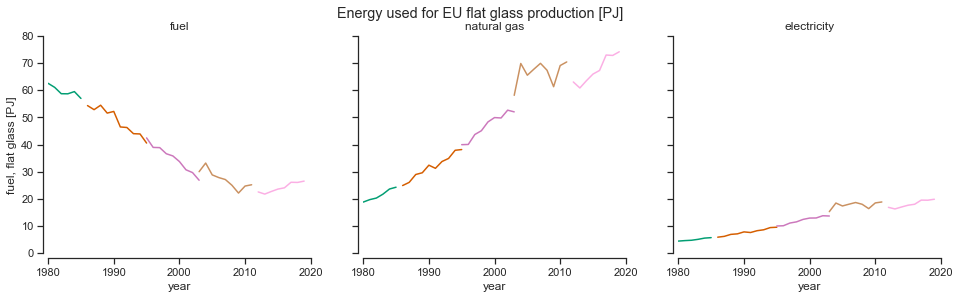

In [96]:
# Plot energy used for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{energy}, flat glass [PJ]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(energy)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 80)
    ax.get_legend().remove()

fig.suptitle("Energy used for EU flat glass production [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

In [97]:
EU['Total energy, flat glass [PJ]'] = 0

for energy in energies:
    EU['Total energy, flat glass [PJ]'] = (
        EU[f"{energy}, flat glass [PJ]"]
        + EU['Total energy, flat glass [PJ]']
    )

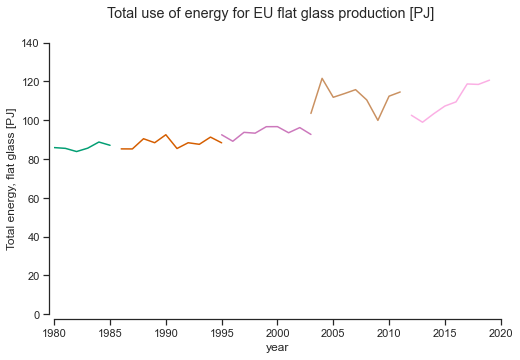

In [98]:
# Plot total energy use for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total energy, flat glass [PJ]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 140)
ax.get_legend().remove()

fig.suptitle("Total use of energy for EU flat glass production [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## Use of raw materials in the production of architectural flat glass

In [99]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    EU[f"{mat}, arch glass [kt]"] = (
        EU['Architectural glass production [kt]']
        * MatIntensity[(f"{mat}, kg/kg")]
    )

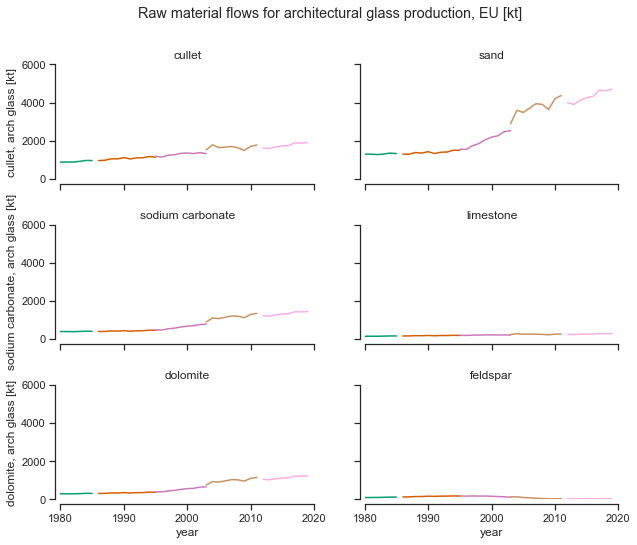

In [100]:
# Plot raw material flows for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{material}, arch glass [kt]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(material)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 6000)
    ax.get_legend().remove()

fig.suptitle("Raw material flows for architectural glass production, EU [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

In [101]:
EU['Total raw materials, arch glass [Mt]'] = 0

for material in materials:
    EU['Total raw materials, arch glass [Mt]'] = (
        EU[f"{material}, arch glass [kt]"]/1000
        + EU['Total raw materials, arch glass [Mt]']
    )

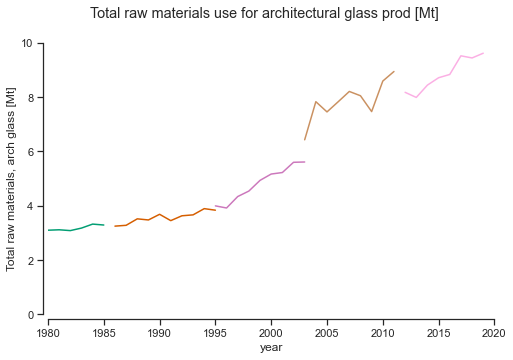

In [102]:
# Plot total material flows for EU architectural glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, arch glass [Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 10)
ax.get_legend().remove()

fig.suptitle("Total raw materials use for architectural glass prod [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## Energy Use in the production of architectural flat glass

In [103]:
# Absolute use of energy for flat glass production:
for energy in energies:
    EU[f"{energy}, arch glass [PJ]"] = (
        EU['Architectural glass production [kt]']
        * EnergyIntensity[(f"{energy}, GJ/t")]/1000
    )

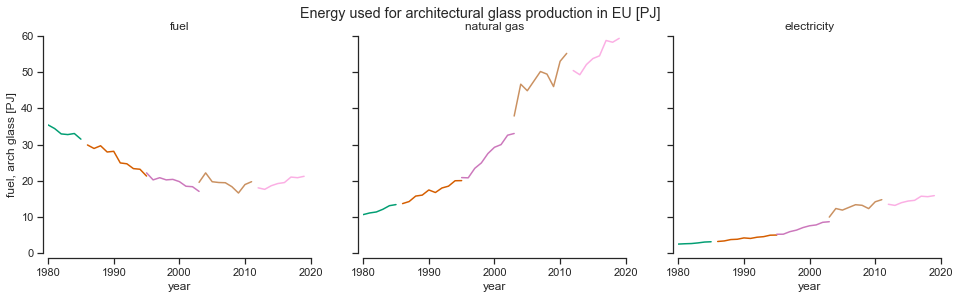

In [104]:
# Plot energy used for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{energy}, arch glass [PJ]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(energy)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 60)
    ax.get_legend().remove()

fig.suptitle("Energy used for architectural glass production in EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

In [105]:
EU['Total energy, arch glass [PJ]'] = 0

for energy in energies:
    EU['Total energy, arch glass [PJ]'] = (
        EU[f"{energy}, arch glass [PJ]"]
        + EU['Total energy, arch glass [PJ]']
    )

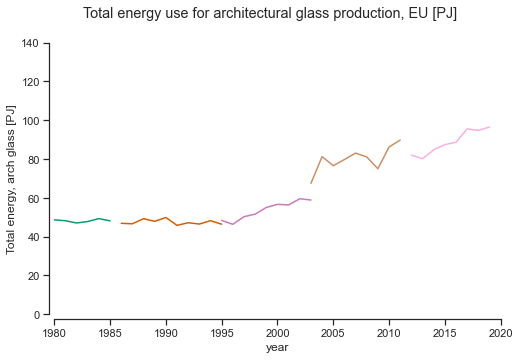

In [106]:
# Plot total energy use for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total energy, arch glass [PJ]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1980, 2020)
ax.set_ylim(0, 140)
ax.get_legend().remove()

fig.suptitle("Total energy use for architectural glass production, EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## Summary

# Raw Material and Energy Use in the Belgian and French Flat Glass Industry

## Use of raw materials in the production of flat glass

In [107]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    for country in BE_FR['Production [kt]'].columns:
        BE_FR[(f"{mat}, flat glass [kt]", country)] = (
            BE_FR[('Production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

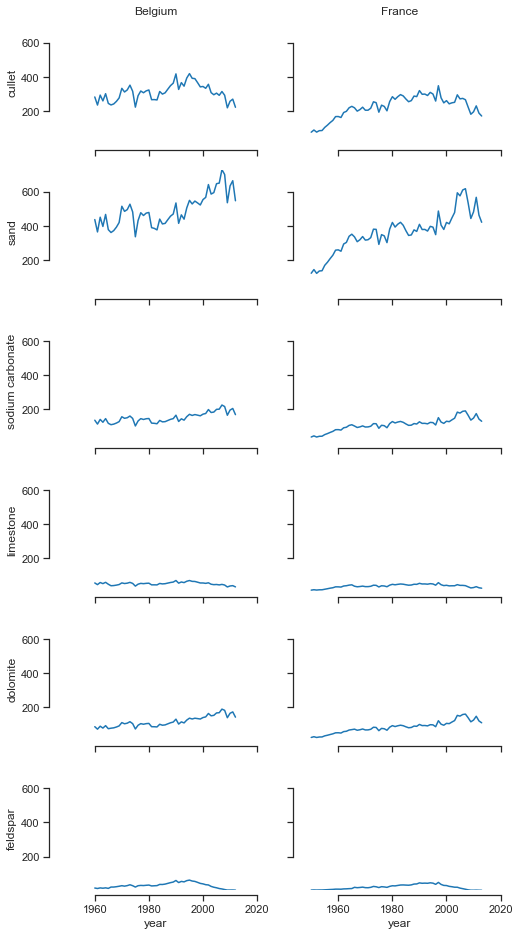

In [108]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16))
for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR[(f"{material}, flat glass [kt]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)

sns.despine(offset=5, trim=True)
plt.show()

In [109]:
BE_FR['Total raw material use, flat glass [kt]'] = 0

for material in materials:
    BE_FR['Total raw material use, flat glass [kt]'] = (
        BE_FR[(f"{material}, flat glass [kt]", country)]
        + BE_FR['Total raw material use, flat glass [kt]']
    )

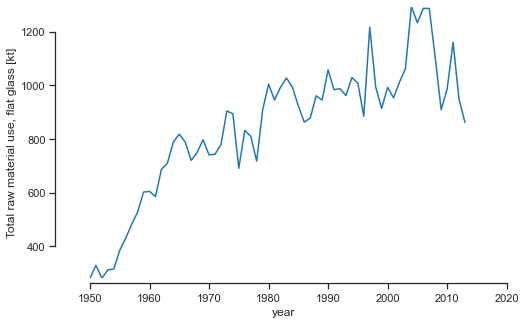

In [110]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=BE_FR,
             x=BE_FR.index,
             y='Total raw material use, flat glass [kt]',
             ax=ax)

ax.set_xlim(1945, 2020)
sns.despine(offset=5, trim=True)
plt.show()

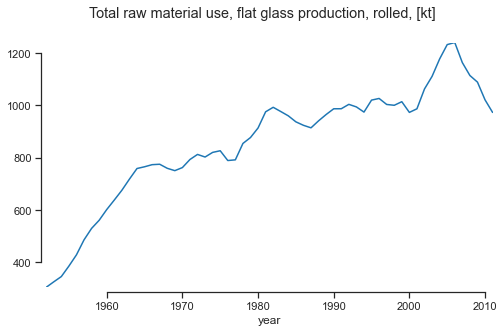

In [111]:
(BE_FR['Total raw material use, flat glass [kt]']
 .rolling(5, center=True)
 .mean()).plot(subplots=True,
               grid=False,
               figsize=(8, 5),
               sharex=True, sharey=True,
               title=(
                   "Total raw material use, flat glass production, rolled, [kt]")
               )

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
sns.despine(offset=5, trim=True)
plt.show()

## Energy Use in the production of flat glass

In [112]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR['Production [kt]'].columns:
        BE_FR[(f"{energy}, flat glass [TJ]", country)] = (
            BE_FR[('Production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")]
        )

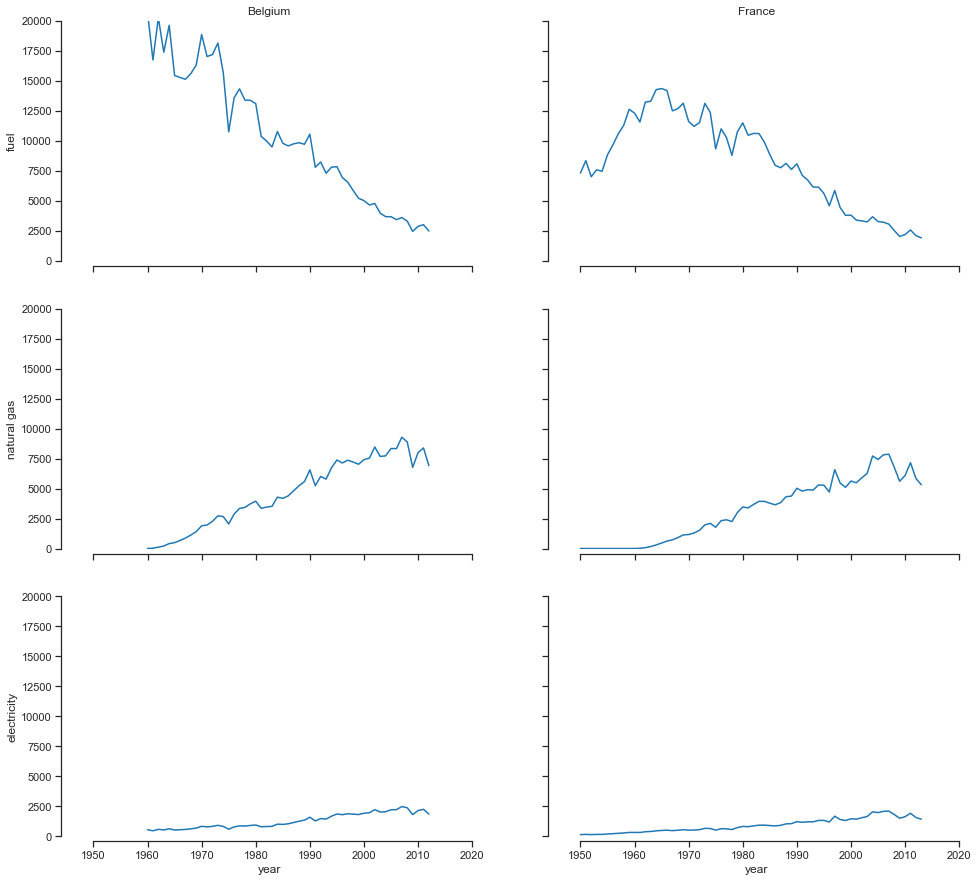

In [113]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 15))
for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR[(f"{energy}, flat glass [TJ]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 20000)

sns.despine(offset=5, trim=True)
plt.show()

In [114]:
BE_FR['Total energy use, flat glass [TJ]'] = 0

for energy in energies:
    BE_FR['Total energy use, flat glass [TJ]'] = (
        BE_FR[(f"{energy}, flat glass [TJ]", country)]
        + BE_FR['Total energy use, flat glass [TJ]']
    )

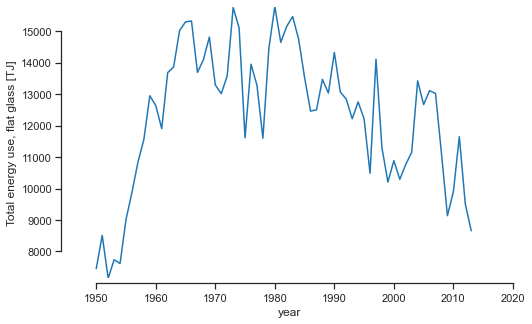

In [115]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=BE_FR,
             x=BE_FR.index,
             y='Total energy use, flat glass [TJ]',
             ax=ax)

ax.set_xlim(1945, 2020)
sns.despine(offset=5, trim=True)
plt.show()

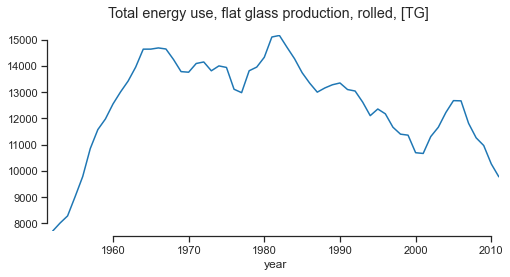

In [116]:
(BE_FR['Total energy use, flat glass [TJ]']
 .rolling(5, center=True)
 .mean()).plot(subplots=True,
               grid=False,
               figsize=(8, 4),
               sharex=True, sharey=True,
               title=("Total energy use, flat glass production, rolled, [TG]")
               )

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
sns.despine(offset=5, trim=True)
plt.show()

## Use of raw materials in the production of architectural flat glass

In [117]:
# Absolute use of raw materials for architectural flat glass production:
for mat in materials:
    for country in BE_FR['Architectural glass production [kt]'].columns:
        BE_FR[(f"{mat}, architectural glass [kt]", country)] = (
            BE_FR[('Architectural glass production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

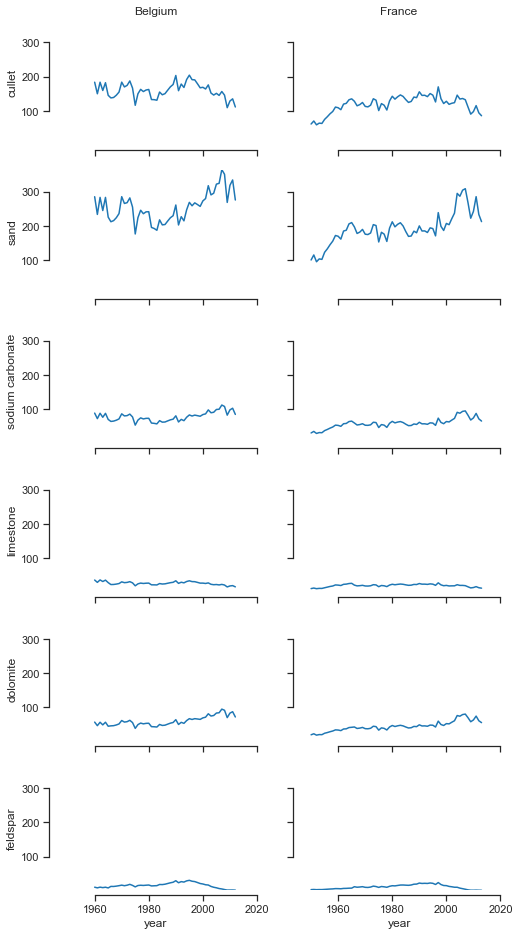

In [118]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16)
                         )

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR[(f"{material}, architectural glass [kt]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)

sns.despine(offset=5, trim=True)
plt.show()

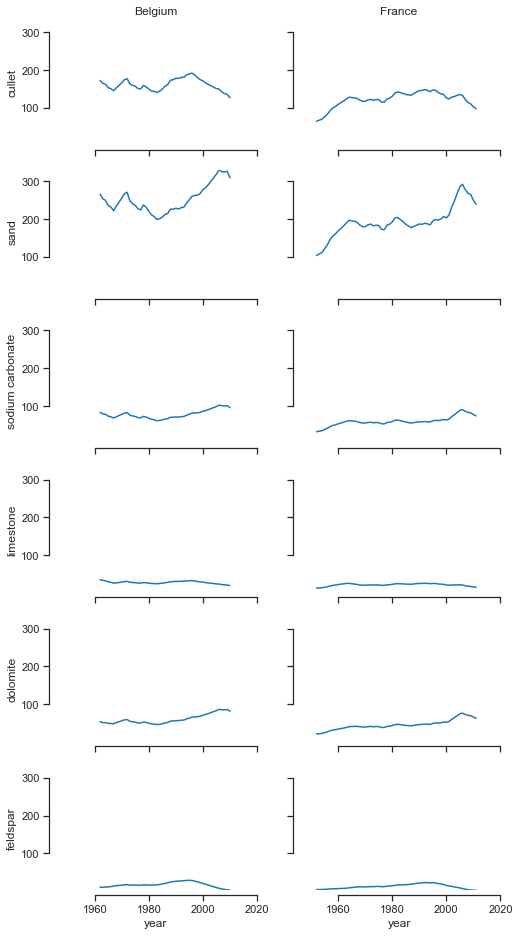

In [119]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16)
                         )

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        (BE_FR[(f"{material}, architectural glass [kt]", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax)
         )

ax.set_xlim(1945, 2020)

sns.despine(offset=5, trim=True)
plt.show()

In [120]:
BE_FR['Total raw material use, architectural glass [kt]'] = 0

for material in materials:
    BE_FR['Total raw material use, architectural glass [kt]'] = (
        BE_FR[(f"{material}, architectural glass [kt]", country)]
        + BE_FR['Total raw material use, architectural glass [kt]']
    )

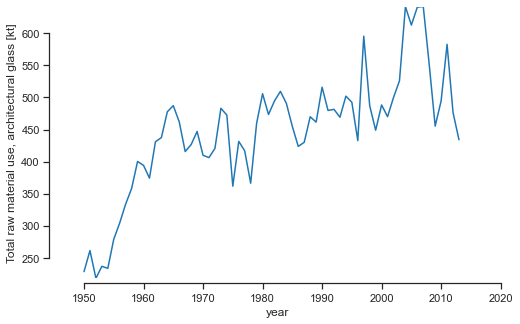

In [121]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=BE_FR,
             x=BE_FR.index,
             y='Total raw material use, architectural glass [kt]',
             ax=ax)

ax.set_xlim(1945, 2020)
sns.despine(offset=5, trim=True)
plt.show()

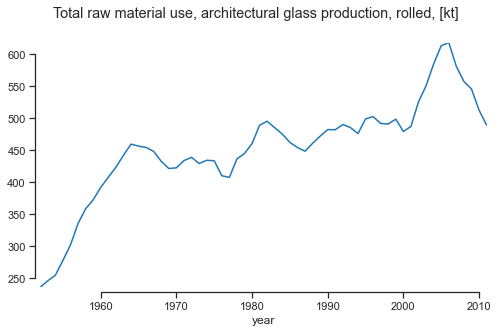

In [122]:
(BE_FR['Total raw material use, architectural glass [kt]']
 .rolling(5, center=True)
 .mean()).plot(subplots=True,
               grid=False,
               figsize=(8, 5),
               sharex=True, sharey=True,
               title=(
                   "Total raw material use, architectural glass production, rolled, [kt]")
               )

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
sns.despine(offset=5, trim=True)
plt.show()

## Energy Use in the production of architectural flat glass

In [123]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR['Architectural glass production [kt]'].columns:
        BE_FR[(f"{energy}, architectural glass [TJ]", country)] = (
            BE_FR[('Architectural glass production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")]
        )

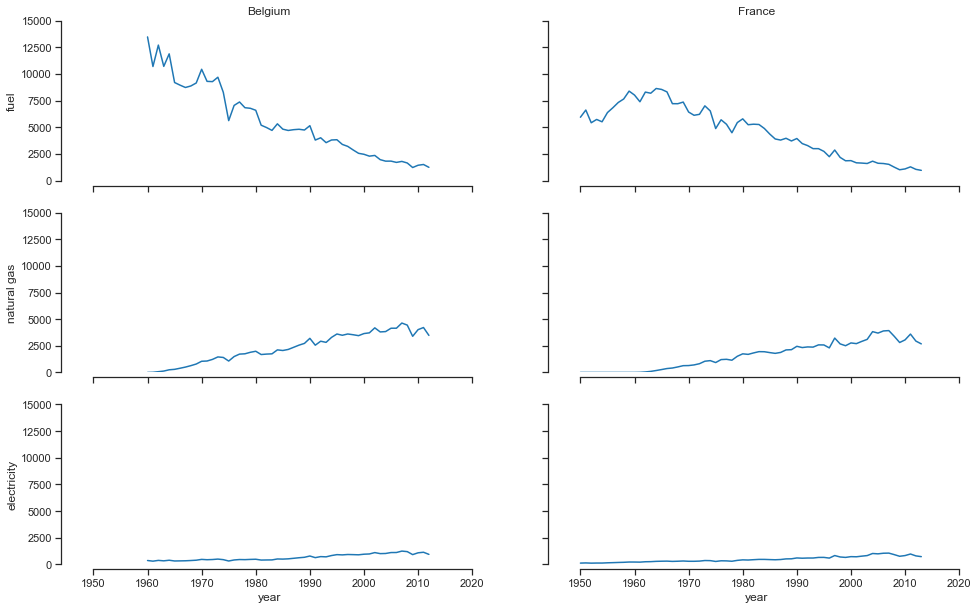

In [124]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10)
                         )

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR[(f"{energy}, architectural glass [TJ]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 15000)

sns.despine(offset=5, trim=True)
plt.show()

In [125]:
BE_FR['Total energy use, architectural glass [TJ]'] = 0

for energy in energies:
    BE_FR['Total energy use, architectural glass [TJ]'] = (
        BE_FR[(f"{energy}, architectural glass [TJ]", country)]
        + BE_FR['Total energy use, architectural glass [TJ]']
    )

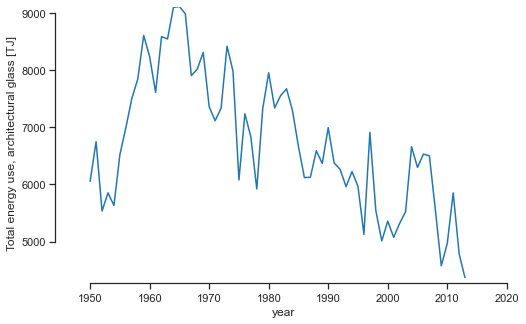

In [126]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=BE_FR,
             x=BE_FR.index,
             y='Total energy use, architectural glass [TJ]',
             ax=ax)

ax.set_xlim(1945, 2020)
sns.despine(offset=5, trim=True)
plt.show()

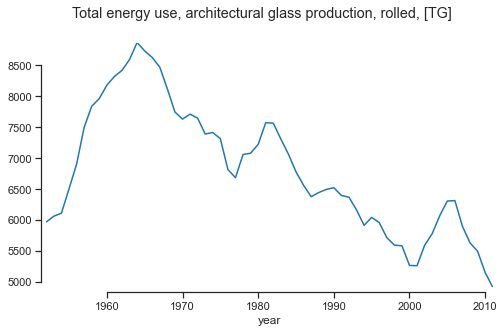

In [127]:
((BE_FR['Total energy use, architectural glass [TJ]']
  .rolling(5, center=True)
  .mean())
 .plot(subplots=True,
       grid=False,
       figsize=(8, 5),
       sharex=True, sharey=True,
       title=("Total energy use, architectural glass production, rolled, [TG]")
       )
 )

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
sns.despine(offset=5, trim=True)
plt.show()

## Summary

# The CO2 Emissions of the Flat Glass Iindustry

## Absolute CO2 Emissions, Europe

In [128]:
# Estimating the CO2 emission related to flat glass production
EU['CO2, flat glass [kt]'] = (
    EU['Production [kt]']
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

In [129]:
# Estimating the CO2 emission related to architectural flat glass production
EU['CO2, architectural glass [kt]'] = (
    EU['Architectural glass production [kt]']
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

In [130]:
CO2_G = ['CO2, flat glass [kt]', 'CO2, architectural glass [kt]']

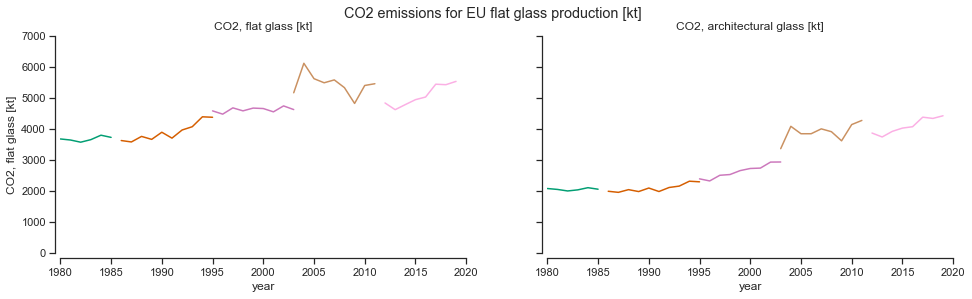

In [131]:
EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, CO2) in enumerate(zip(axes.flatten(), CO2_G)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{CO2}",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(CO2)
    ax.set_xlim(1980, 2020)
    ax.set_ylim(0, 7000)
    ax.get_legend().remove()

fig.suptitle("CO2 emissions for EU flat glass production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

## Absolute CO2 Emissions in Belgium and France since 1945


In [132]:
# Estimating the CO2 emission related to flat glass production
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('CO2, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [133]:
# Estimating the CO2 emission related to architectural flat glass production
for country in BE_FR['Architectural glass production [kt]'].columns:
    BE_FR[('CO2, architectural glass [kt]', country)] = (
        BE_FR[('Architectural glass production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

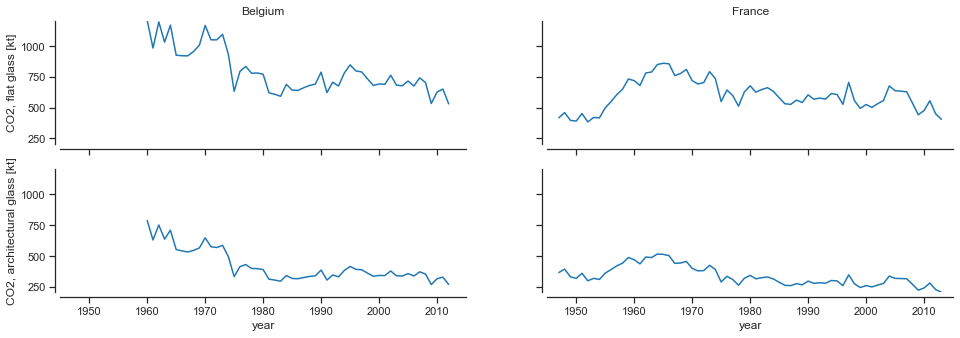

In [134]:
nrows = len(CO2_G)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))
for row, CO2 in enumerate(CO2_G):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        BE_FR[(f"{CO2}", country)].plot(ax=ax)

ax.set_xlim(1945, 2015)
sns.despine(offset=5)
plt.show()

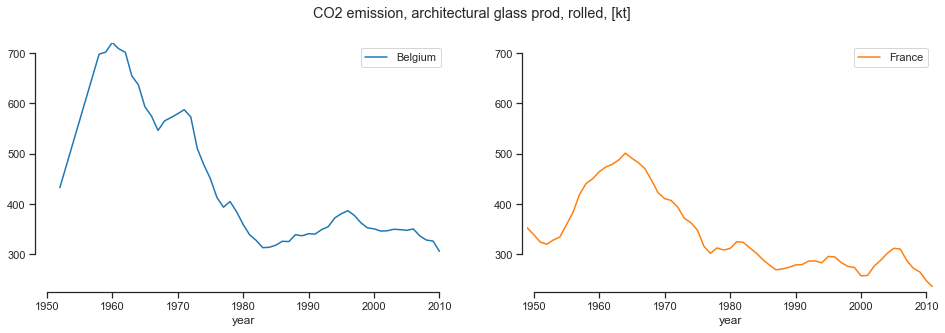

In [135]:
# Rolling and plotting the CO2 emission related to architectural glass prod
with sns.plotting_context("notebook"):
    # Rolling flat glass production according to a 5-year mean
    (BE_FR['CO2, architectural glass [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center=True)
     .mean()).plot(subplots=True,
                   grid=False,
                   layout=(1, 2),
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title=(
                       "CO2 emission, architectural glass prod, rolled, [kt]")
                   )

    ax.set_xlim(1945, 2015)
    ax.set_ylim(ymin=0)
    sns.despine(offset=5, trim=True)
    plt.show()

## Base 100 Analysis, France and Belgium

In [136]:
# Base 100 = 1980
FGProd_diff = (100 * BE_FR['Production [kt]']
               / BE_FR['Production [kt]'].loc[1980]
               )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff = (100 * BE_FR['CO2, flat glass [kt]']
               / BE_FR['CO2, flat glass [kt]'].loc[1980]
               )

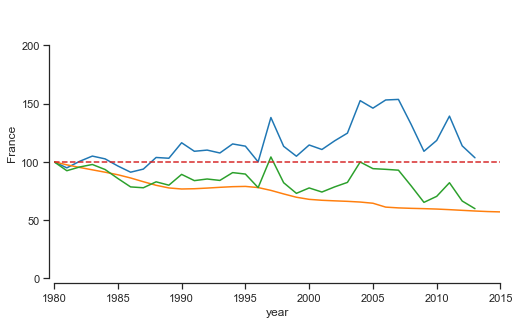

In [137]:
# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=FGProd_diff,
             x=FGProd_diff.index,
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index,
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff.index,
        CO2ABS_diff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980, 2015)
ax.set_ylim(ymin=0)
sns.despine(offset=5, trim=True)
plt.show()

In [138]:
# Base 100 = 1980, with a 5-year rolling
FGProd_diff_roll = (100 * BE_FR['Production [kt]']
                    .rolling(5, center=True).mean()
                    / BE_FR['Production [kt]']
                    .rolling(5, center=True).mean().loc[1980])

CO2ABS_diff_roll = (100 * (BE_FR['CO2, flat glass [kt]']
                           .interpolate(method="linear", limit_area='inside')
                           .rolling(5, center=True).mean())
                    / (BE_FR['CO2, flat glass [kt]']
                       .interpolate(method="linear", limit_area='inside')
                       .rolling(5, center=True).mean().loc[1980])
                    )

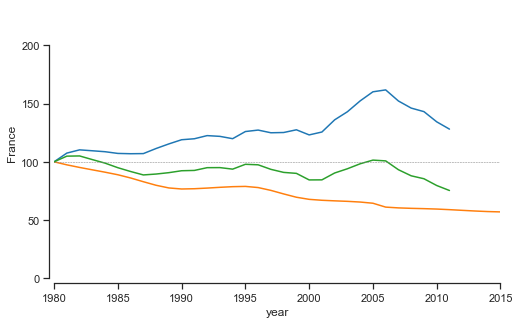

In [139]:
# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=FGProd_diff_roll,
             x=FGProd_diff_roll.index,
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index,
        CO2Intensity_diff['CO2 interpolated [kg/t]'])

ax.plot(CO2ABS_diff_roll.index,
        CO2ABS_diff_roll['France'])

ax.plot([1980, 2015], [100, 100], '--', c='grey', linewidth=0.5)

ax.set_xlim(1980, 2015)
ax.set_ylim(ymin=0)
sns.despine(offset=5, trim=True)
plt.show()

## Summary